In [1]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

from svgpathtools import parse_path

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/spatial/__init__.py:96: ImportWarning: Not importing directory '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/spatial/qhull': missing __init__.py
  from .qhull import *
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/optimize/_minimize.py:37: ImportWarning: Not importing directory '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/optimize/lbfgsb': missing __init__.py
  from .lbfgsb import _minimize_lbfgsb


## setup

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['graphical_conventions']

# which iteration name should we use?
iterationName = 'run3_size4_waiting'

In [4]:
## get total number of stroke and clickedObj events in the collection as a whole
S = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'stroke'}]}).sort('time')
C = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.'

7562 stroke records in the database.
1379 clickedObj records in the database.


## generate group dataframe

In [5]:
## list of researcher mturk worker ID's to ignore
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
megsano = ['A1DVQQLVZR7W6I']
researchers = jefan + hawkrobe + megsano

In [6]:
reload(h)
## get list of all candidate games
games = coll.distinct('gameid')

## get list of complete and valid games
_complete_games = h.get_complete_and_valid_games(games,coll,iterationName,researchers=researchers, tolerate_undefined_worker=False)

There are 34 complete games in total.


In [7]:
reload(h)
# preprocessing 

TrialNum = []
GameID = []
Condition = []
Target = []
Category = []
Distractor1 = []
Distractor2 = []
Distractor3 = []
Outcome = []
Response = []
Repetition = []
Phase = []
numStrokes = []
drawDuration = [] # in seconds
svgStringLength = [] # sum of svg string for whole sketch
svgStringLengthPerStroke = [] # svg string length per stroke
numCurvesPerSketch = [] # number of curve segments per sketch
numCurvesPerStroke = [] # mean number of curve segments per stroke
svgStringStd = [] # std of svg string length across strokes for this sketch
Outcome = [] #accuracy (True or False)
png=[] # the sketch 
timedOut=[] # True if sketchers didn't draw anything, False o.w.
meanPixelIntensity=[]

#y = ['7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb', '7527-5ab8c64c-3f95-4864-bb6a-f9cad4b0d34e']
#__complete_games= [item for item in complete_games if item not in y]

for i,g in enumerate(_complete_games):
        print 'Analyzing game {} | {} of {}: '.format(g, i, len(_complete_games))

        # collection of all clickedObj events in a particular game 
        X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
        # collection of all stroke events in a particular game 
        Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')

        for t in X: # for each clickedObj event
            targetname = t['intendedName']
            category = h.OBJECT_TO_CATEGORY_run2[targetname]
            Phase.append(t['phase'])
            Repetition.append(t['repetition'])
            distractors = [t['object2Name'],t['object3Name'],t['object4Name']]
            full_list = [t['intendedName'],t['object2Name'],t['object3Name'],t['object4Name']] 
            png.append(t['pngString'])

#             #for each stroke event with same trial number as this particular clickedObj event 
            y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
    
            # have to account for cases in which sketchers do not draw anything 
            if (y.count() == 0):
                numStrokes.append(float('NaN'))
                drawDuration.append(float('NaN'))
                svgStringLength.append(float('NaN'))
                svgStringLengthPerStroke.append(float('NaN'))
                numCurvesPerSketch.append(float('NaN'))
                numCurvesPerStroke.append(float('NaN'))
                svgStringStd.append(float('NaN'))
                meanPixelIntensity.append('NaN')
                timedOut.append(True)
            else: 
                # calculate numStrokes 
                lastStrokeNum = float(y[y.count() - 1]['currStrokeNum']) # get currStrokeNum at last stroke
                
                #assert lastStrokeNum == ns
                numStrokes.append(lastStrokeNum)
                
                # calculate drawDuration 
                startStrokeTime =  float(y[0]['startStrokeTime'])
                endStrokeTime = float(y[y.count() - 1]['endStrokeTime']) ## took out negative 1 
                duration = (endStrokeTime - startStrokeTime) / 1000
                drawDuration.append(duration)
                
                # calculate other measures that have to do with sketch 
                ls = [len(_y['svgData']) for _y in y]
                svgStringLength.append(sum(ls))
                y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')            
                num_curves = [len([m.start() for m in re.finditer('c',str(_y['svgData']))]) for _y in y] ## gotcha: need to call string on _y['svgData'], o/w its unicode and re cant do anything with it
                numCurvesPerSketch.append(sum(num_curves))
                numCurvesPerStroke.append(sum(num_curves)/lastStrokeNum)
                svgStringLengthPerStroke.append(sum(ls)/lastStrokeNum)
                svgStringStd.append(np.std(ls))
                timedOut.append(False)
                
                ## calculate pixel intensity (amount of ink spilled) 
                imsize = 100
                numpix = imsize**2
                thresh = 250
                imgData = t['pngString']
                filestr = base64.b64decode(imgData)
                fname = os.path.join('sketch.png')
                with open(fname, "wb") as fh:
                    fh.write(imgData.decode('base64'))
                im = Image.open(fname).resize((imsize,imsize))
                _im = np.array(im)
                meanPixelIntensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)

            ### aggregate game metadata
            TrialNum.append(t['trialNum'])
            GameID.append(t['gameid'])        
            Target.append(targetname)
            Category.append(category)
            Condition.append(t['condition'])
            Response.append(t['clickedName'])
            Outcome.append(t['correct'])
            Distractor1.append(distractors[0])
            Distractor2.append(distractors[1])
            Distractor3.append(distractors[2])  

Analyzing game 7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb | 0 of 34: 
Analyzing game 3558-8fa206a2-9b8c-4d67-a4ab-0832dc0d0f25 | 1 of 34: 
Analyzing game 6964-d6de9966-f3dd-45df-8d24-d5bfd5d46eb8 | 2 of 34: 
Analyzing game 4853-a05bfdd7-095c-4b93-bdde-2b99fd29c7a2 | 3 of 34: 
Analyzing game 5616-7114c020-0e81-482c-952b-b26fc66076a0 | 4 of 34: 
Analyzing game 9817-6f2a66db-fc24-482d-aa20-1980ad6f524e | 5 of 34: 
Analyzing game 7527-5ab8c64c-3f95-4864-bb6a-f9cad4b0d34e | 6 of 34: 
Analyzing game 1820-86afdf51-4b4c-43a9-a9e1-e6e20618de1b | 7 of 34: 
Analyzing game 7438-c77fa69e-d41c-41a4-b530-fc2809c07323 | 8 of 34: 
Analyzing game 9075-d6c9b0a6-bfb2-4148-ae19-d0da518aef97 | 9 of 34: 
Analyzing game 7637-26870e81-faae-4521-a2e9-10424526a22c | 10 of 34: 
Analyzing game 4395-6cdb78e3-0c3f-4526-9670-8e4c1dcbc542 | 11 of 34: 
Analyzing game 3480-03933bf3-5e7e-4ecd-b151-7ae57e6ae826 | 12 of 34: 
Analyzing game 7360-1ccf92da-d46d-4315-8c81-6620388ee62f | 13 of 34: 
Analyzing game 8103-96ba70c4-9

### svg rendering

In [39]:
import svg_rendering_helpers as srh
reload(srh)

<module 'svg_rendering_helpers' from 'svg_rendering_helpers.pyc'>

In [40]:
from matplotlib.path import Path
import matplotlib.patches as patches

In [154]:
## now actually make dataframe
GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity, svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png = map(np.array, \
[GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut,png])    

Repetition = map(int,Repetition)

_D = pd.DataFrame([GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png], 
                 index = ['gameID','trialNum','condition', 'target', 'category', 'repetition', 'phase', 'drawDuration', 'outcome', 'response', 'numStrokes', 'meanPixelIntensity', 'svgStringLength', 'svgStringLengthPerStroke', 'svgStringStd', 'numCurvesPerSketch', 'numCurvesPerStroke', 'timedOut', 'png'])
_D = _D.transpose()

# filter out crazy games (low accuracy and timeouts)
accuracy_list = []
timed_outs = []

for g in _complete_games:
    D_ = _D[_D['gameID'] == g]
    all_accuracies = [d['outcome'] for i, d in D_.iterrows()]
    mean_accuracy = sum(all_accuracies) / float(len(all_accuracies))
    accuracy_list.append(mean_accuracy)
    if any(d['timedOut'] == True for i, d in D_.iterrows()):
        print "timed out!"
        timed_outs.append(g)
        
arr = np.array(accuracy_list)
med = np.median(arr)
sd = np.std(arr)
crazies = [i for i, acc in enumerate(accuracy_list) if (med-acc)/sd > 3]
crazy_games = [_complete_games[i] for i in crazies]
crazy_games = crazy_games + timed_outs
complete_games= [item for item in _complete_games if item not in crazy_games]                 
D = _D.loc[_D['gameID'].isin(complete_games)]

## save out dataframe to be able to load in and analyze later w/o doing the above mongo querying ...
D.to_csv(os.path.join(results_dir,'graphical_conventions_group_data_{}.csv'.format(iterationName)))

# Just look at one game
#D = D[D['gameID'] == '7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb']

#### normalizing dataframe for within-subjects analysis

In [60]:
### making a copy of dataframe 
D_normalized = D.copy(deep = True)

In [118]:
D_correct = D[D['outcome'] == True]
D_correct_normalized = D_correct.copy(deep=True)

In [62]:
D_normalized = h.grand_mean_normalize(D_normalized, 'numStrokes', complete_games)
D_normalized = h.grand_mean_normalize(D_normalized, 'drawDuration', complete_games)
D_normalized = h.grand_mean_normalize(D_normalized, 'numCurvesPerSketch', complete_games)
D_normalized = h.grand_mean_normalize(D_normalized, 'meanPixelIntensity', complete_games)

In [119]:
D_correct_normalized = h.grand_mean_normalize(D_correct_normalized, 'numStrokes', complete_games)
D_correct_normalized = h.grand_mean_normalize(D_correct_normalized, 'drawDuration', complete_games)
D_correct_normalized = h.grand_mean_normalize(D_correct_normalized, 'numCurvesPerSketch', complete_games)
D_correct_normalized = h.grand_mean_normalize(D_correct_normalized, 'meanPixelIntensity', complete_games)

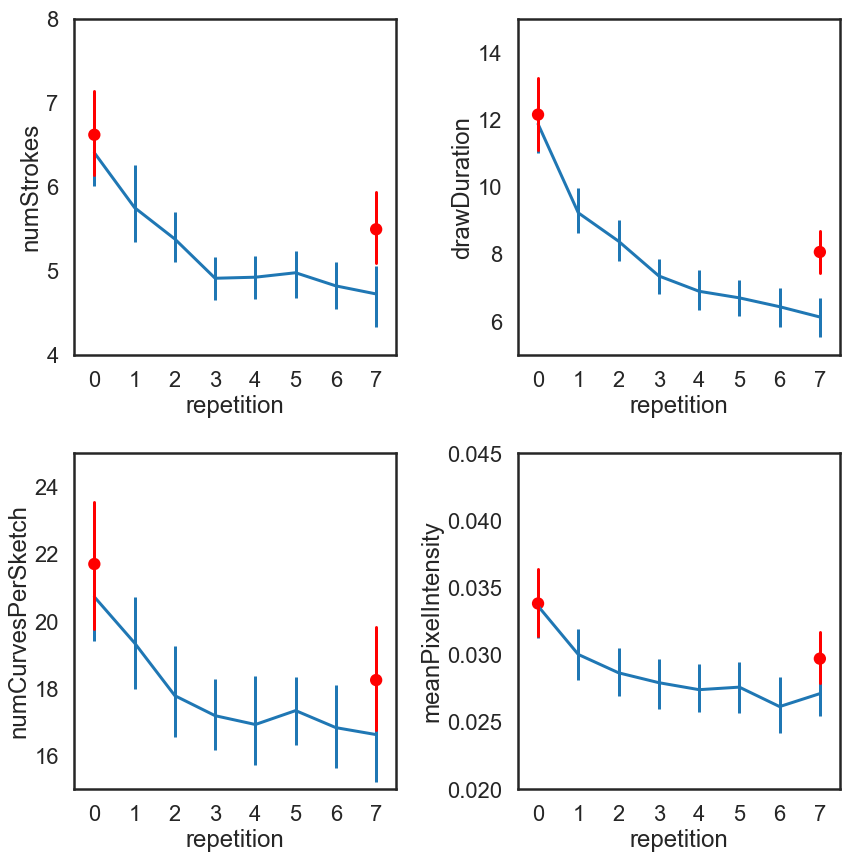

In [134]:
reload(h)
var0='numStrokes'
var1='drawDuration'
var2='numCurvesPerSketch'
var3= 'meanPixelIntensity'
h.ts_grid_repeated_control(D_correct_normalized, 
                                                var0, var1, var2, var3,
                                                numReps=8,
                                                 save_plot=False,
                                                 plot_dir=plot_dir)

##### checking difference vector between repeated and control in pre phase

In [139]:
reload(h)
D_rep_0 = D[(D['condition'] == 'repeated') & (D['phase'] == "pre")]
D_rep_pre = (h.convert_numeric(D_rep_0, 'numStrokes')).groupby('gameID')['numStrokes'].mean()
D_con_0 = D[(D['condition'] == 'control') & (D['phase'] == "pre")]
D_con_pre = (h.convert_numeric(D_con_0, 'numStrokes')).groupby('gameID')['numStrokes'].mean()
dist_list = []
for i in range(len(D_rep_pre)):
    dist = D_rep_pre[i] - D_con_pre[i]
    dist_list.append(dist)
# sns.distplot(D_rep_0['numCurvesPerSketch'], hist = False, color = "red")
# sns.distplot(D_con_0['numCurvesPerSketch'], hist = False, color = "blue")
dist_arr= np.array(dist_list)

In [140]:
def bootstrap_resample(dist_arr, iter=1000):
    total = []
    for i in range(iter):
        n = len(dist_arr)
        resample_i = np.floor(np.random.rand(n)*len(dist_arr)).astype(int)
        X_resample = dist_arr[resample_i]
        total.append(X_resample.mean())
    total_arr = np.array(total)
    return total_arr

In [150]:
lower = np.mean(total_arr) - 1.96 * np.std(total_arr)
upper = np.mean(total_arr) + 1.96 * np.std(total_arr)
print np.mean(total_arr)
print np.std(total_arr)

-0.333393939394
0.349196895737


In [146]:
print lower, upper

-1.01781985504 0.351031976251


In [144]:
total_arr = bootstrap_resample(dist_arr)
#print 'original mean: ', dist_list.mean()
#print 'resampled mean: ', dist_resample.mean()

-1.9733636363636362

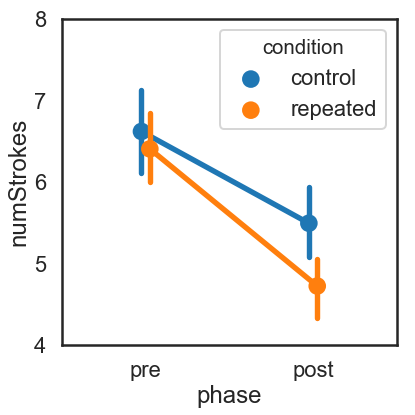

In [148]:
reload(h)
D1 = h.compare_conditions_prepost(D_correct_normalized,
                                var='numStrokes',
                                lower_limit = 4,
                                upper_limit=8,
                                save_plot=False,
                                plot_dir=plot_dir)

### confusion matrix for each category

In [13]:
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

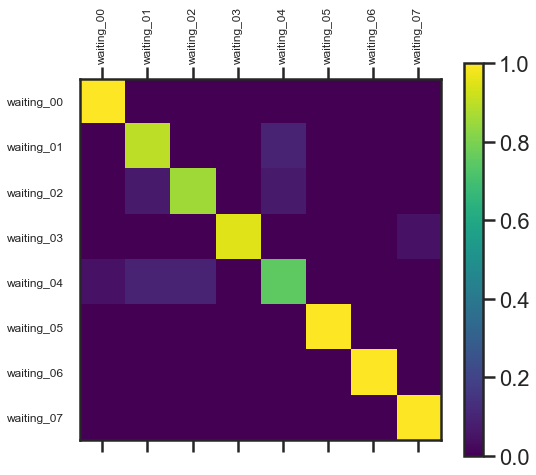

In [14]:
h.get_confusion_matrix(D, 'waiting', 4)

##### confusion matrix for rep 0 and 7

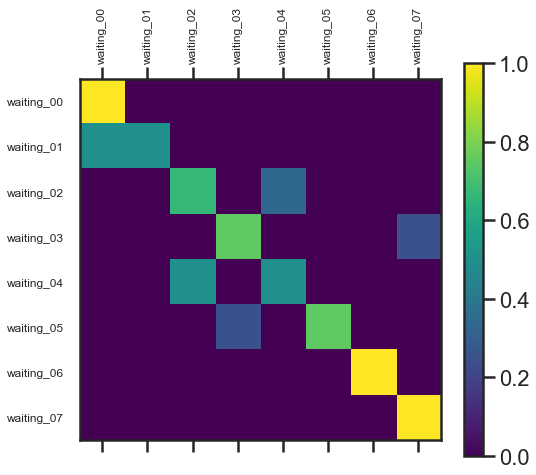

In [50]:
reload(h)
h.get_confusion_matrix_on_rep(D, 'waiting', 4, 0)

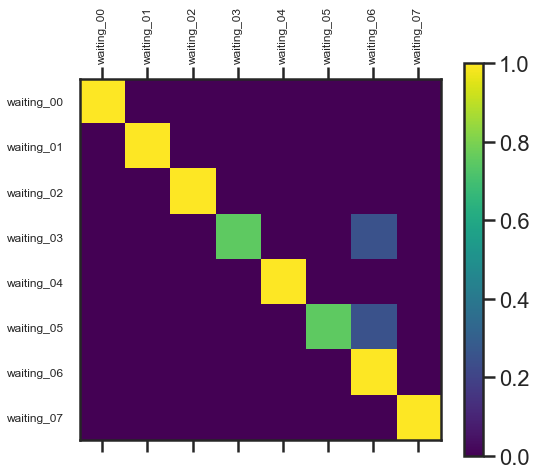

In [51]:
h.get_confusion_matrix_on_rep(D, 'waiting', 4, 7)

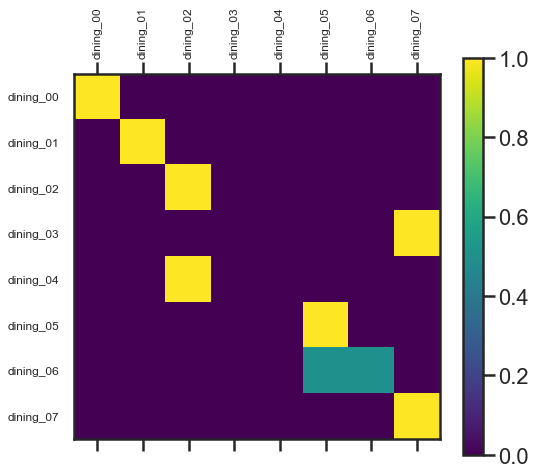

In [52]:
h.get_confusion_matrix_on_rep(D, 'dining', 4, 0)

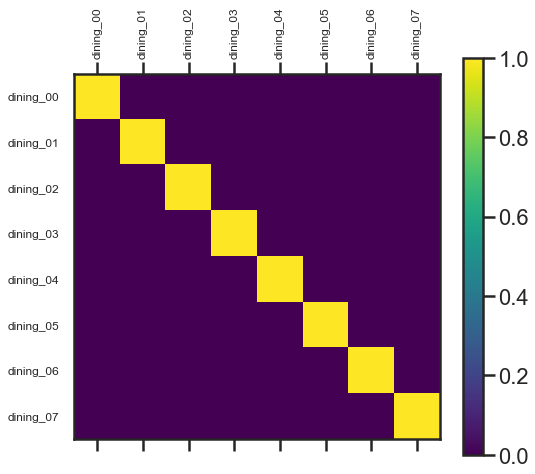

In [53]:
h.get_confusion_matrix_on_rep(D, 'dining', 4, 7)

## visualize behavioral measures over time

In [132]:
# reload analysis_helpers just to be on the safe side 
reload(h)

## set seaborn style params here
sns.set_context('poster')
sns.set_style('white')

##### Accuracy over time

In [121]:
total = 0
for outcome in D['outcome']:
    total = total + outcome 
meanAccuracy = total / len(D['outcome'])
meanAccuracy

0.87656250000000002

([<matplotlib.axis.XTick at 0x1a185e7dd0>,
 <a list of 8 Text xticklabel objects>)

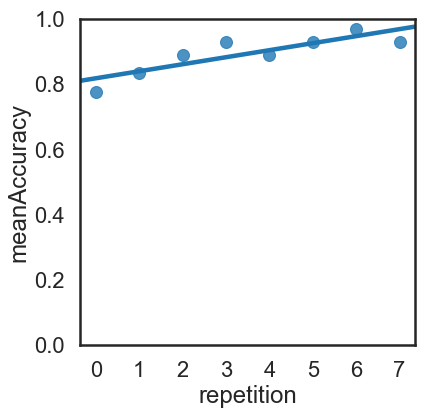

In [122]:
mean_accuracy_list = []
for i in range(0,8):
    outcome_list = (D.loc[D['repetition'] == i])['outcome']
    mean_accuracy = sum(outcome_list) / float(len(outcome_list))
    mean_accuracy_list.append(mean_accuracy)
D_mean = pd.DataFrame()
D_mean['meanAccuracy'] = mean_accuracy_list
D_mean['repetition'] = range(0,8)
D_mean
plt.figure(figsize=(6,6))
sns.regplot(data=D_mean,
         x='repetition',
         y='meanAccuracy',
         ci = None)    
plt.ylim([0,1.0])
plt.xticks(np.arange(0, 8, step=1))

### plot time series during repetition phase 

##### individual measures across reps (repeated + control)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


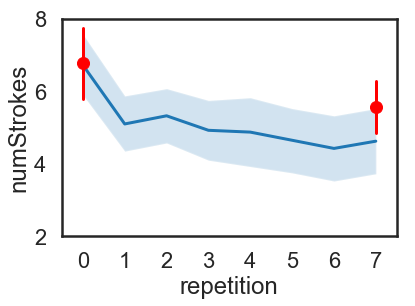

In [42]:
dv = 'numStrokes'
reload(h)
h.ts_repeated_control(D, 
                        var=dv,
                        numReps = 8,
                        upper_limit=8,
                        lower_limit = 2,# recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
                        save_plot=False,
                        plot_dir=plot_dir)

##### 4 measures (2x2) across reps (repeated + control) 

In [123]:
# What are the four measures that you want to visualize across reps? 
var0='numStrokes'
var1='drawDuration'
var2='numCurvesPerSketch'
var3= 'meanPixelIntensity'

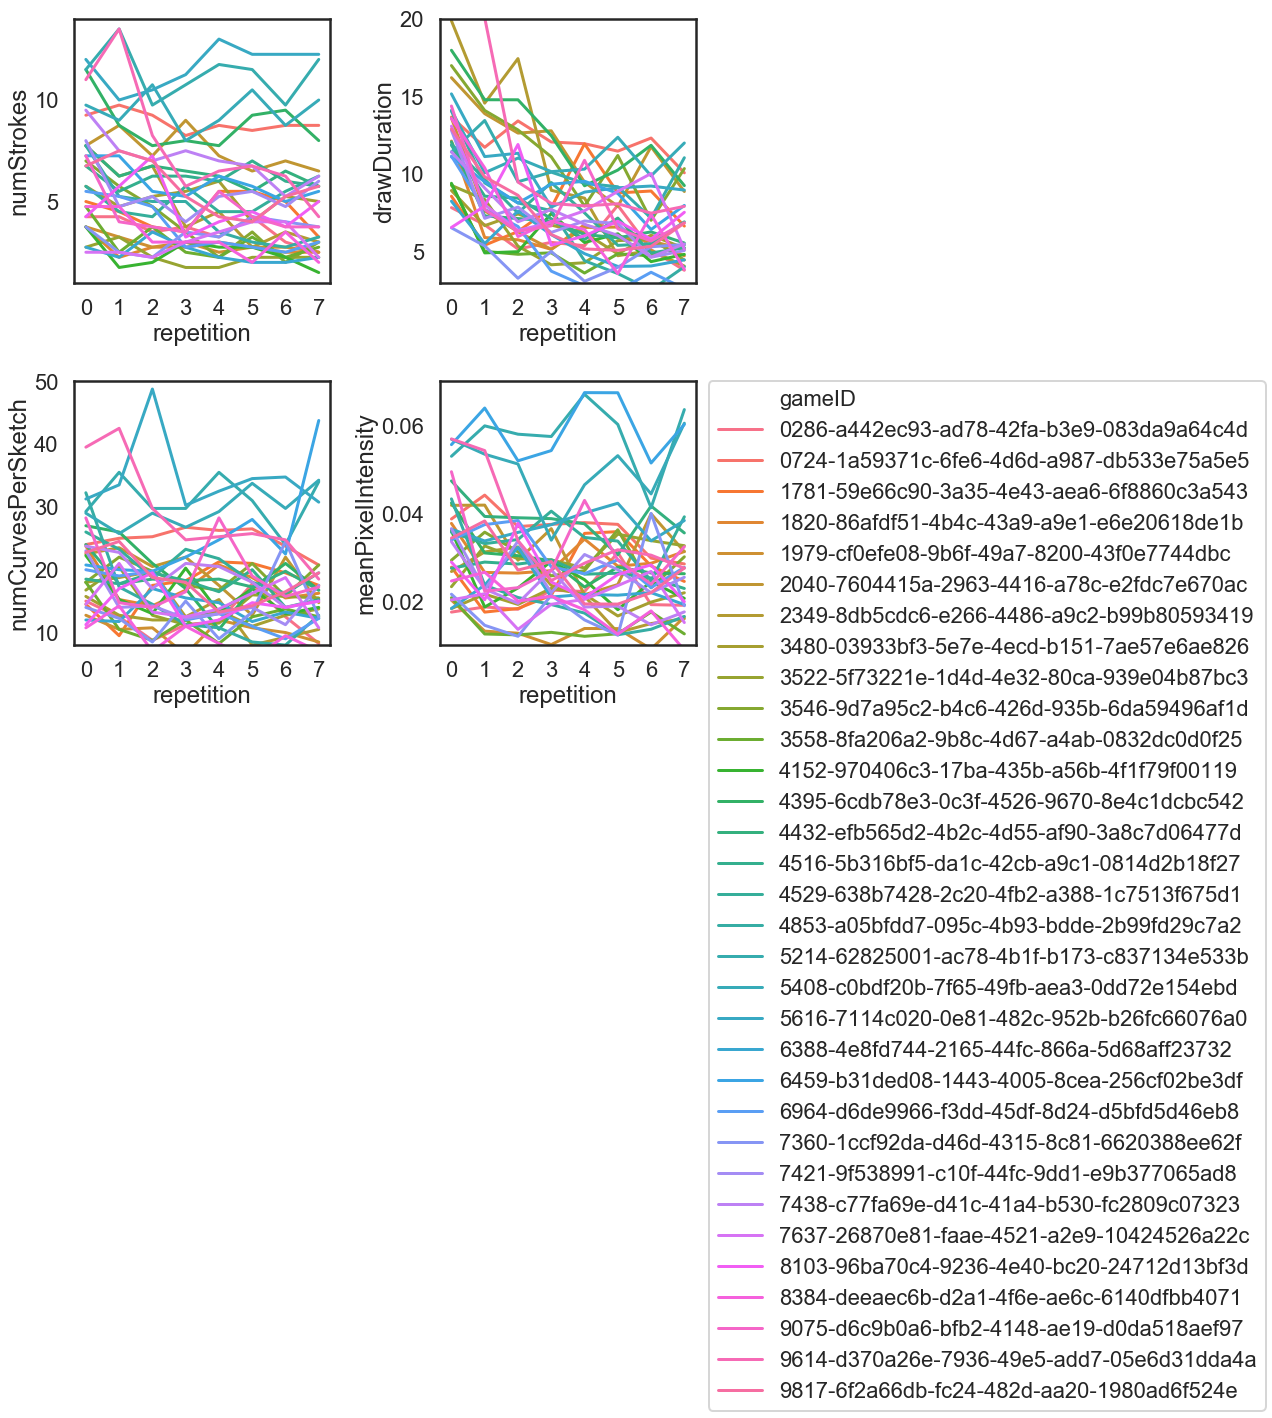

In [124]:
reload(h)
h.line_grid_individual(D, 
                                      var0, var1, var2, var3,
                                       numReps=8,
                                      save_plot=False,
                                      plot_dir=plot_dir)

In [125]:
# What are the four measures that you want to visualize across reps? 
var0='numStrokes'
var1='drawDuration'
var2='numCurvesPerSketch'
var3= 'meanPixelIntensity'

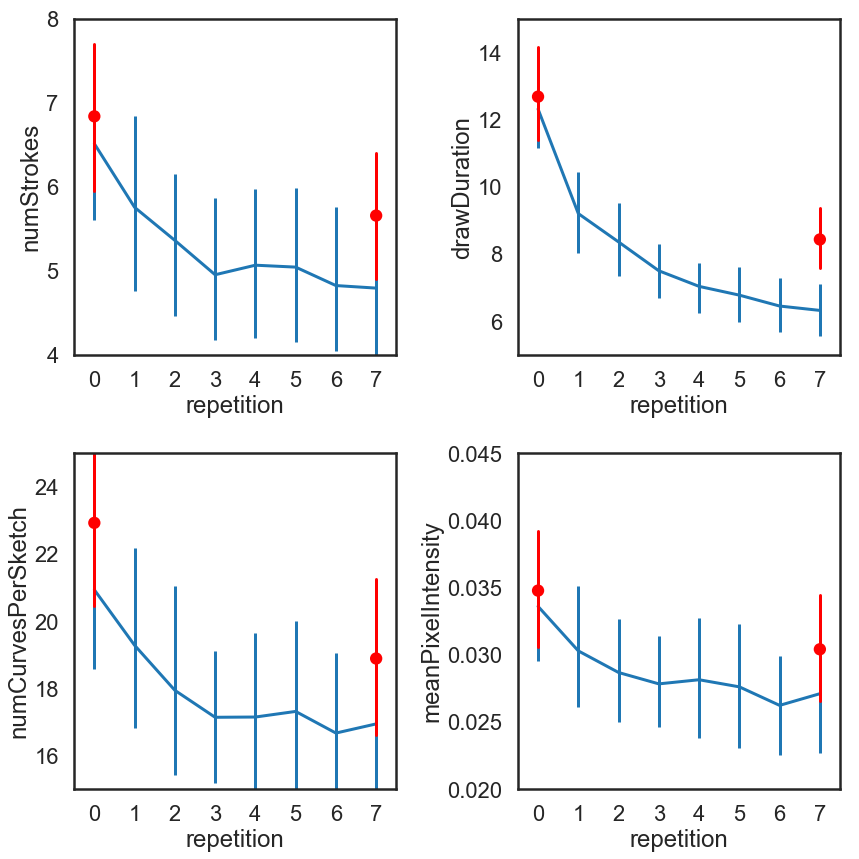

In [147]:
reload(h)
h.ts_grid_repeated_control(D, 
                                                var0, var1, var2, var3,
                                                numReps=8,
                                                 save_plot=False,
                                                 plot_dir=plot_dir)

### compare conditions in pre and post phases 

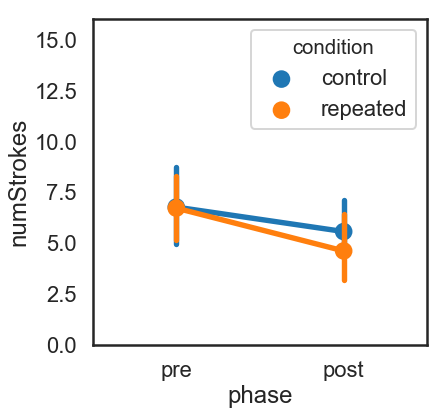

In [37]:
reload(h)
D1 = h.compare_conditions_prepost(D,
                                var='numStrokes',
                                limit=16,
                                save_plot=False,
                                plot_dir=plot_dir)

##### compare accuracy in pre and post phases (repeated vs control conditions)

In [127]:
for i, o in enumerate(D['outcome']):
    if o == True:
        D.set_value(i, 'outcome', 1)
    else:
        D.set_value(i, 'outcome', 0)
D['outcome'] = D['outcome'].astype(int)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 1.1)

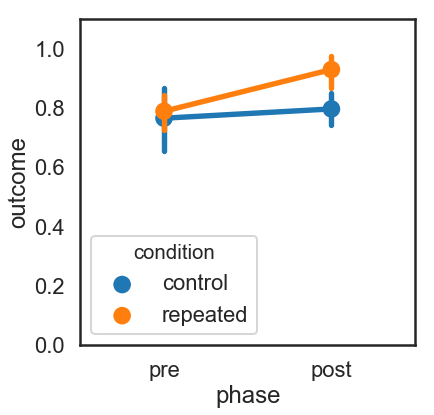

In [128]:
_D1 = D[D['phase']!='repeated'] ## exclude "repetition-phase" trials
D1 = _D1.groupby(['gameID','phase','condition'])['outcome'].mean()
D1 = D1.reset_index()    

plt.figure(figsize=(6,6))
sns.pointplot(data=D1,
         x='phase',
         y='outcome',
         hue='condition',
         order=['pre','post'])    
plt.ylim([0,1.1])
#plt.savefig(os.path.join(plot_dir,'timeseries_across_reps_{}.pdf'.format(var))) 
#return D1    

 ### visualize how sketches are changing across repetitions

##### printing actual sketches next to repeated sketches

Printing out sketches from game: 3558-8fa206a2-9b8c-4d67-a4ab-0832dc0d0f25
Printing out sketches from game: 6964-d6de9966-f3dd-45df-8d24-d5bfd5d46eb8
Printing out sketches from game: 4853-a05bfdd7-095c-4b93-bdde-2b99fd29c7a2
Printing out sketches from game: 5616-7114c020-0e81-482c-952b-b26fc66076a0
Printing out sketches from game: 9817-6f2a66db-fc24-482d-aa20-1980ad6f524e
Printing out sketches from game: 1820-86afdf51-4b4c-43a9-a9e1-e6e20618de1b
Printing out sketches from game: 7438-c77fa69e-d41c-41a4-b530-fc2809c07323
Printing out sketches from game: 9075-d6c9b0a6-bfb2-4148-ae19-d0da518aef97
Printing out sketches from game: 7637-26870e81-faae-4521-a2e9-10424526a22c
Printing out sketches from game: 4395-6cdb78e3-0c3f-4526-9670-8e4c1dcbc542
Printing out sketches from game: 3480-03933bf3-5e7e-4ecd-b151-7ae57e6ae826
Printing out sketches from game: 7360-1ccf92da-d46d-4315-8c81-6620388ee62f
Printing out sketches from game: 8103-96ba70c4-9236-4e40-bc20-24712d13bf3d
Printing out sketches fro

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Printing out sketches from game: 2040-7604415a-2963-4416-a78c-e2fdc7e670ac
Printing out sketches from game: 8384-deeaec6b-d2a1-4f6e-ae6c-6140dfbb4071
Printing out sketches from game: 6388-4e8fd744-2165-44fc-866a-5d68aff23732
Printing out sketches from game: 1979-cf0efe08-9b6f-49a7-8200-43f0e7744dbc
Printing out sketches from game: 2349-8db5cdc6-e266-4486-a9c2-b99b80593419
Printing out sketches from game: 9614-d370a26e-7936-49e5-add7-05e6d31dda4a
Printing out sketches from game: 6459-b31ded08-1443-4005-8cea-256cf02be3df


KeyboardInterrupt: 

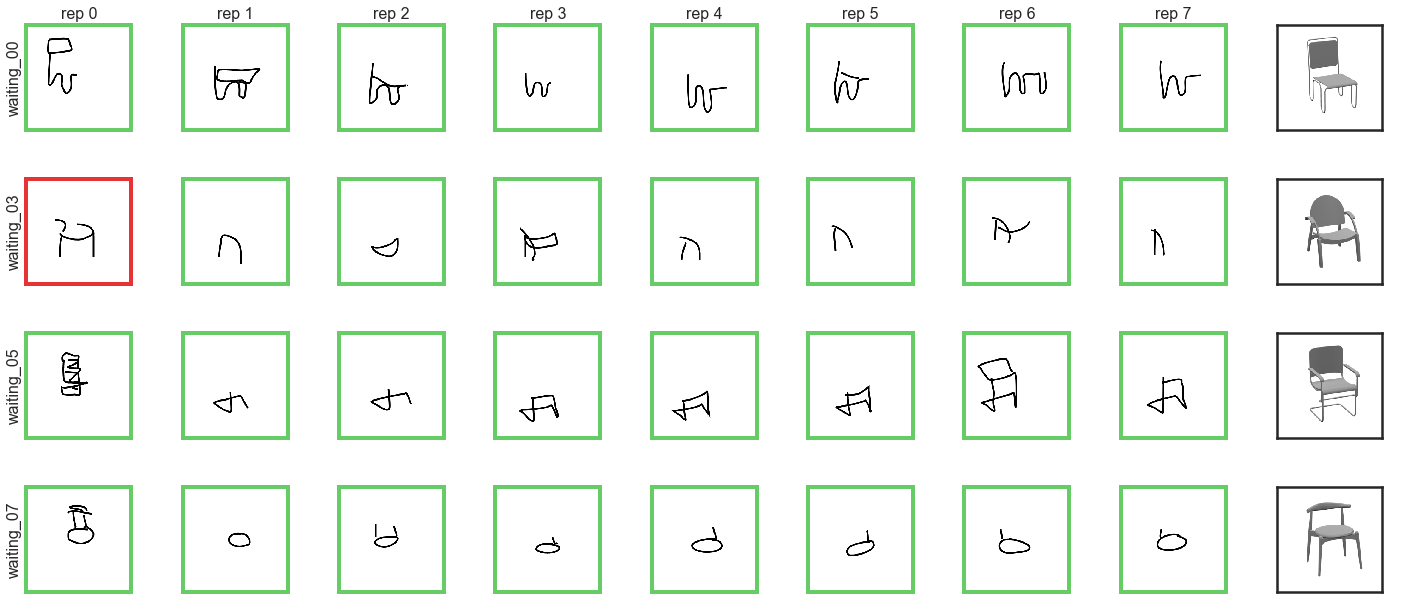

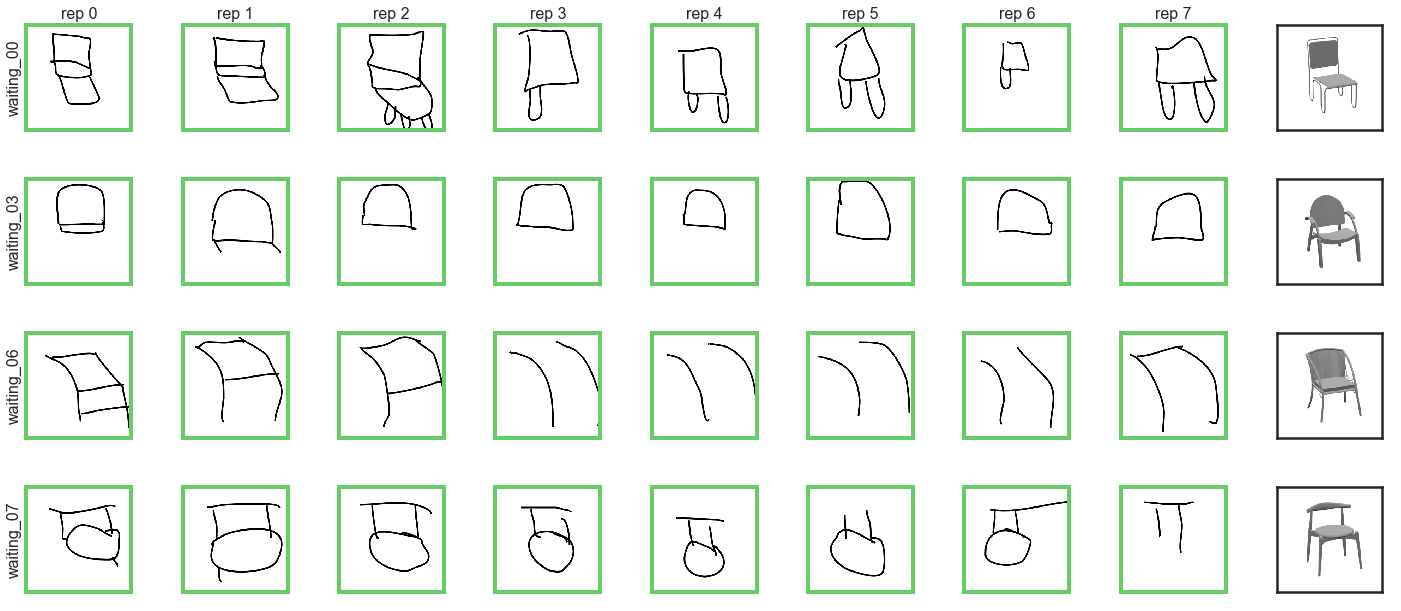

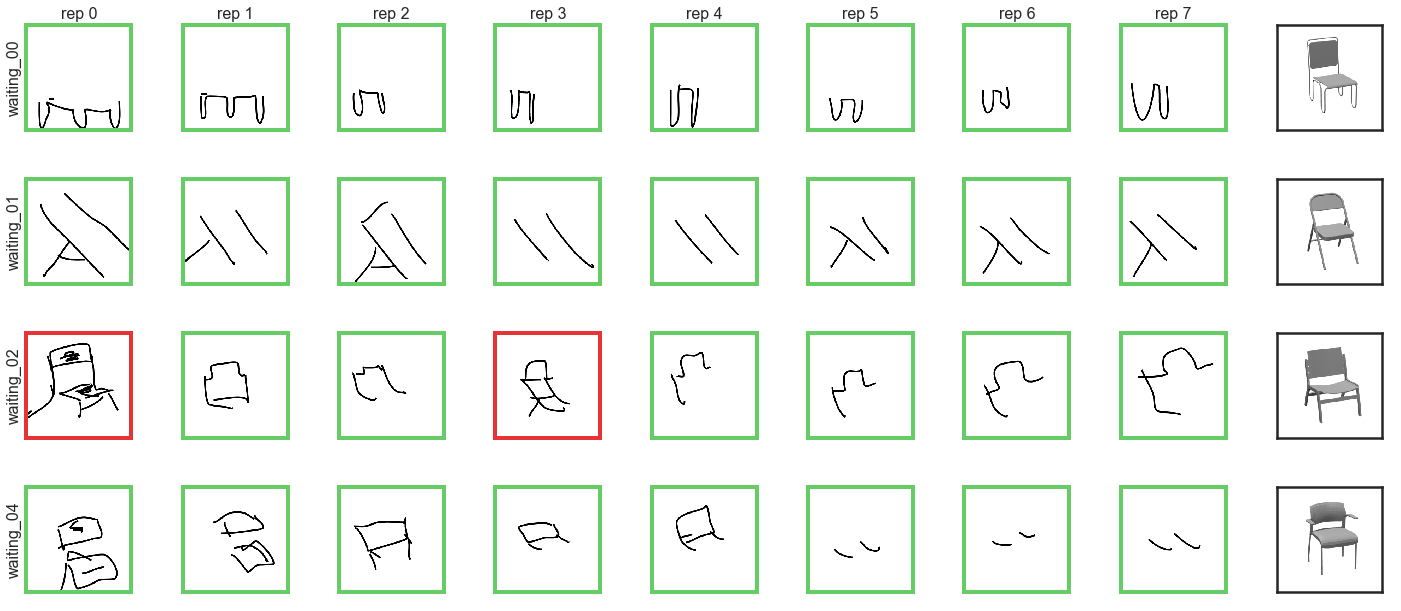

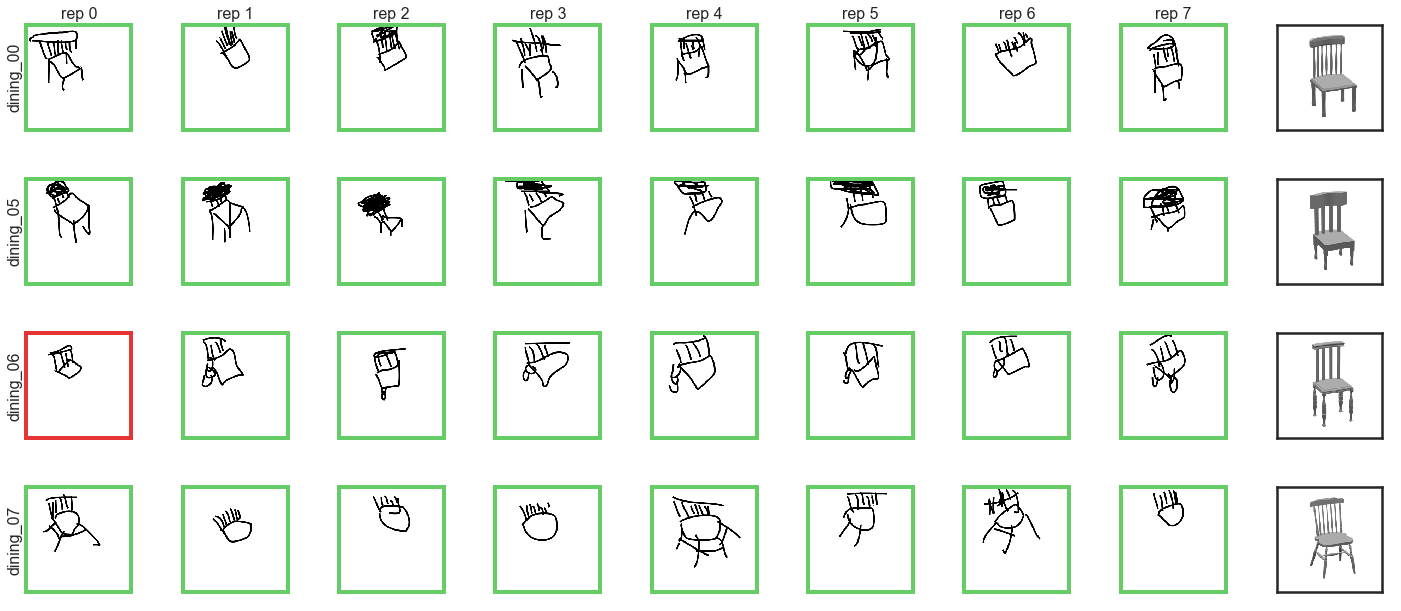

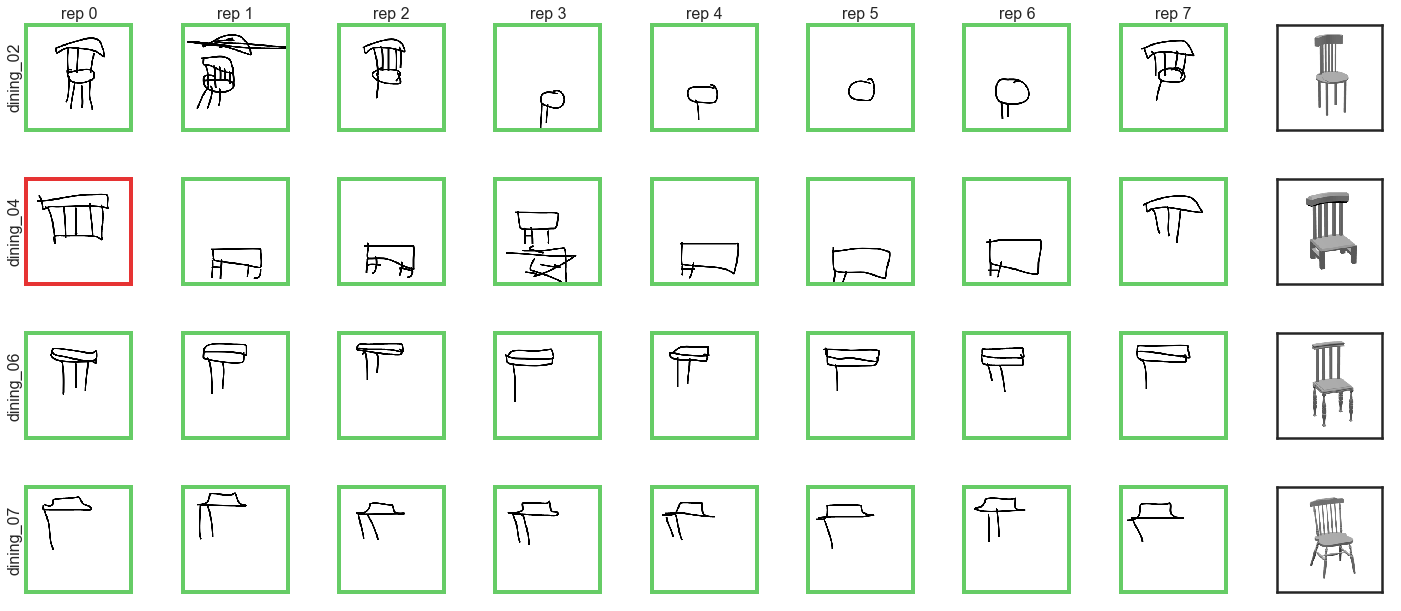

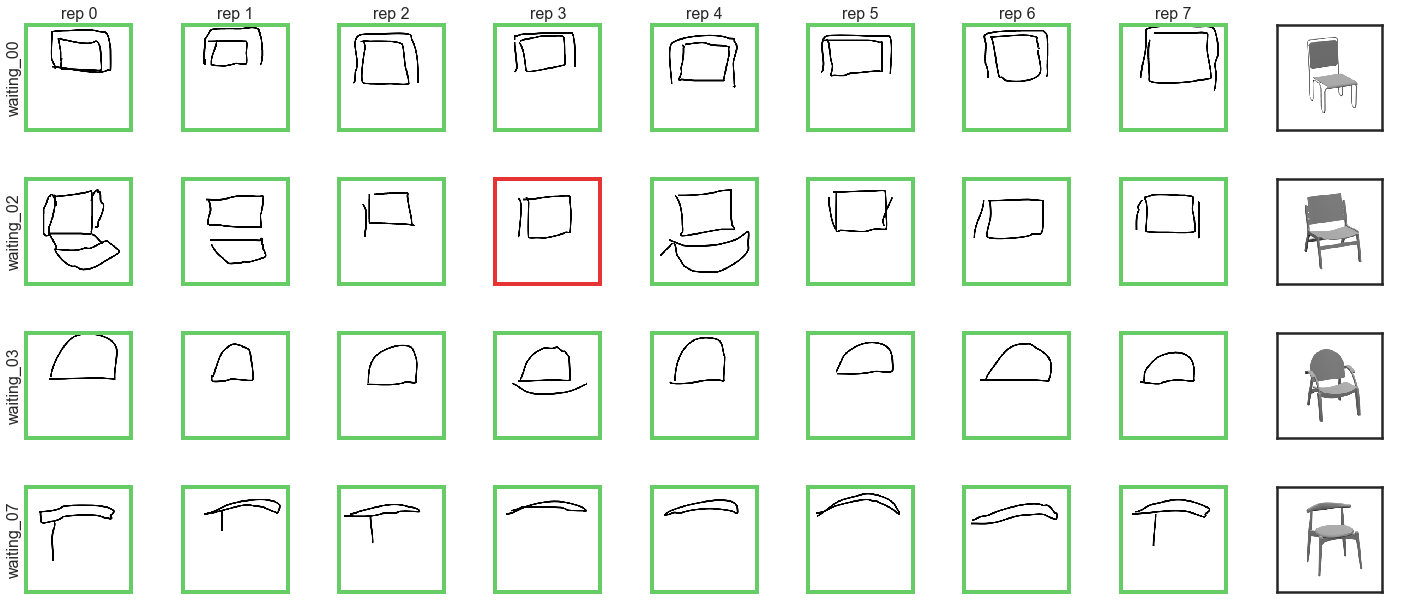

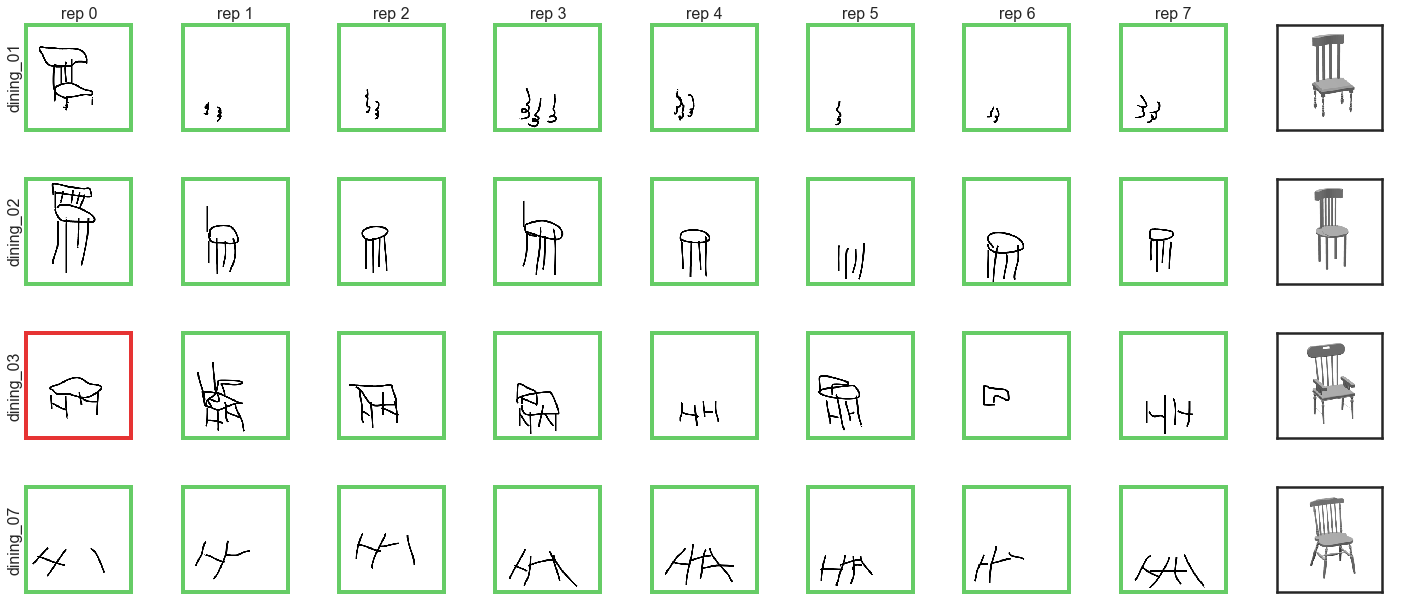

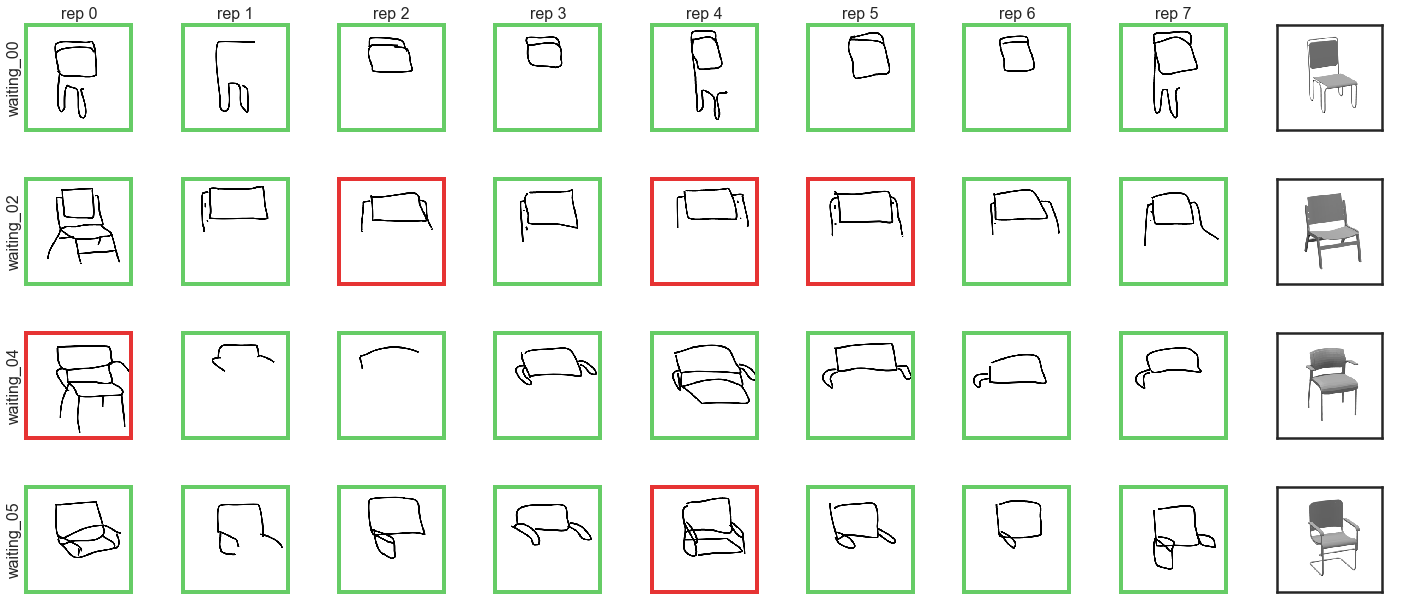

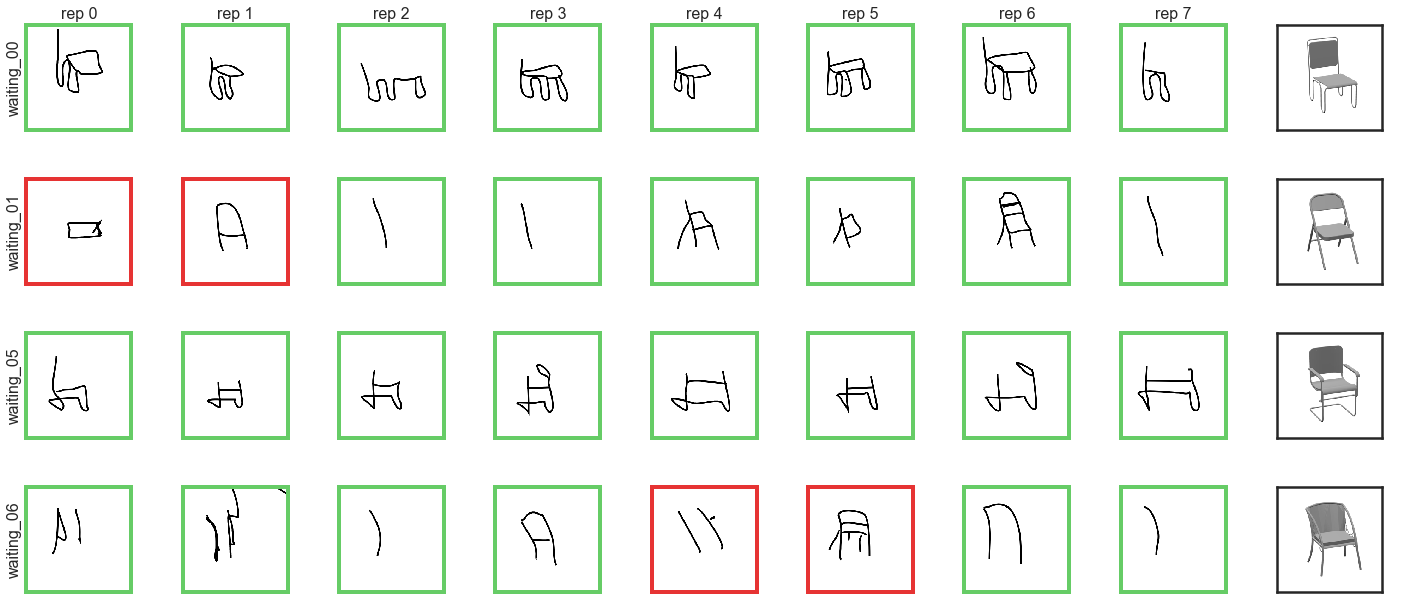

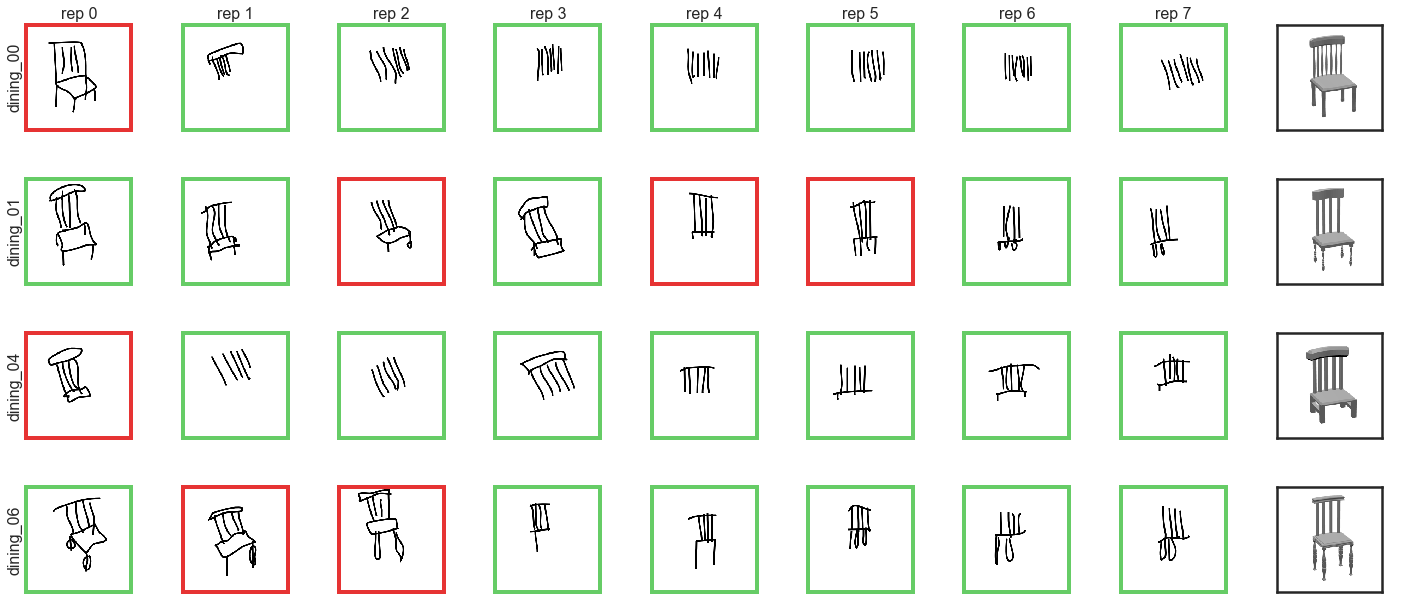

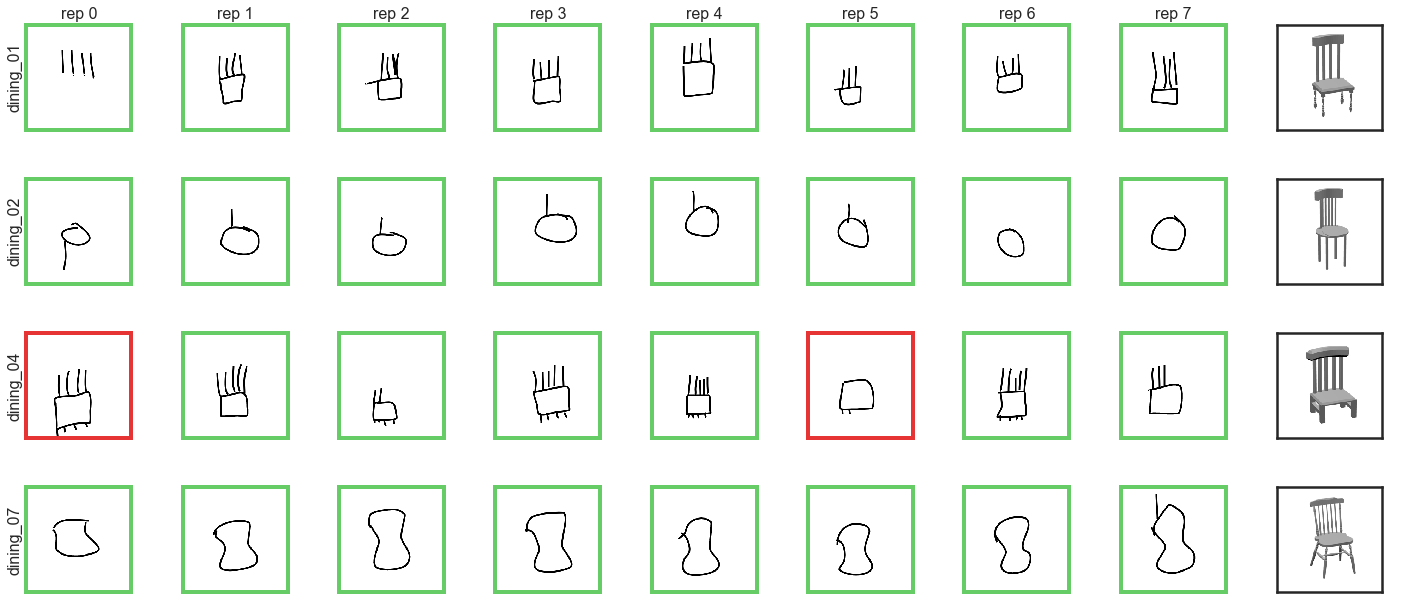

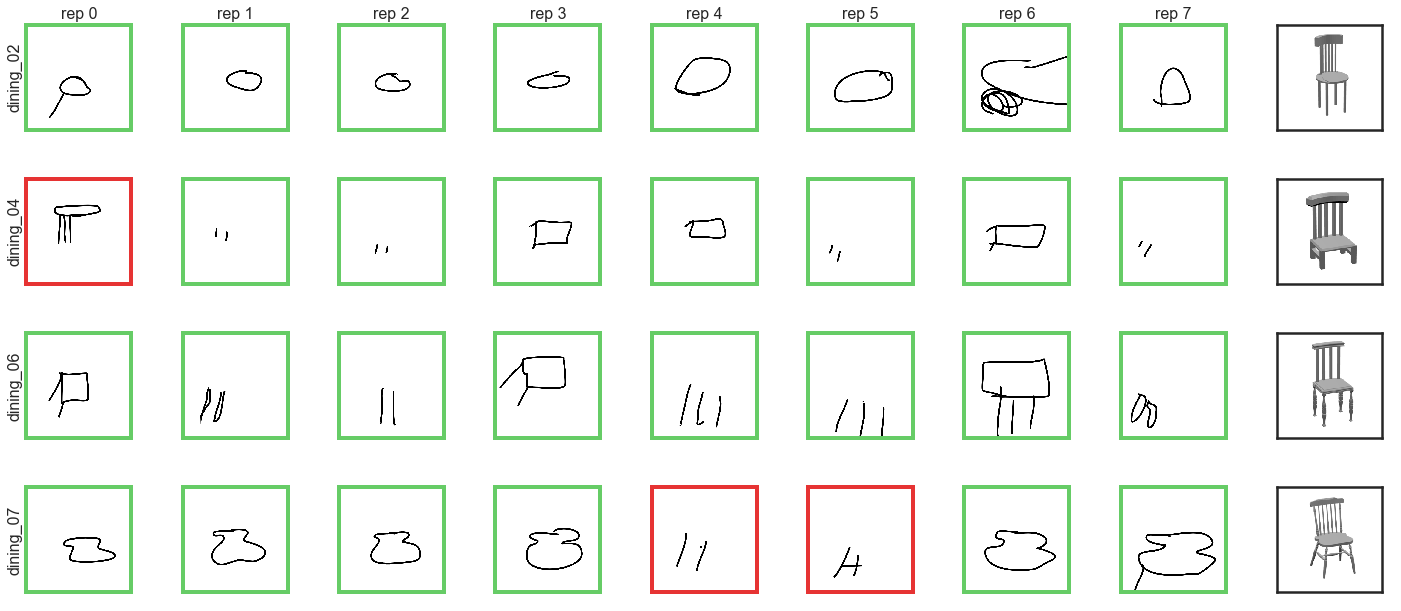

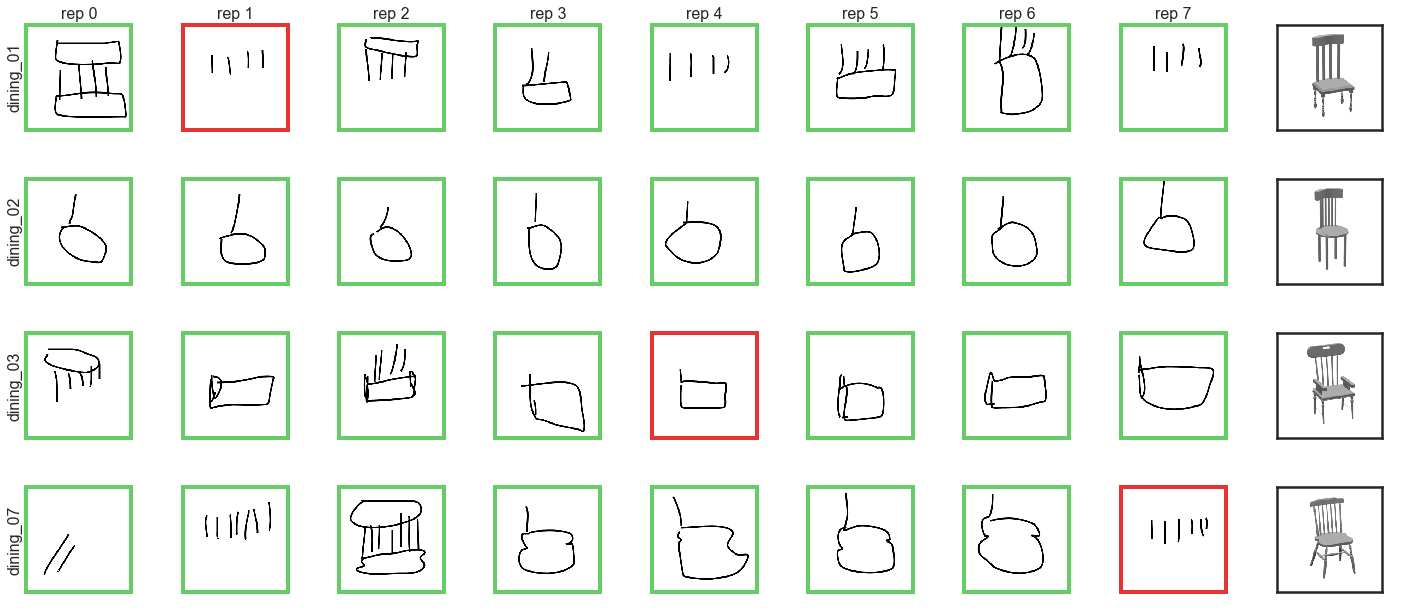

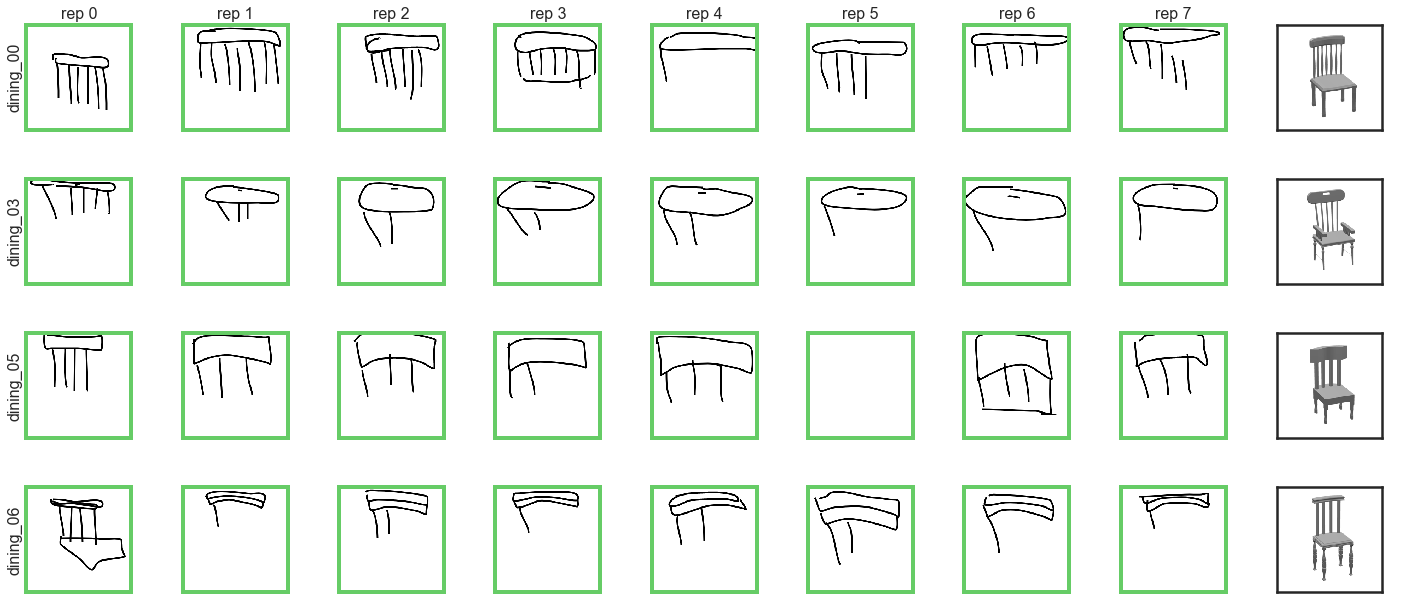

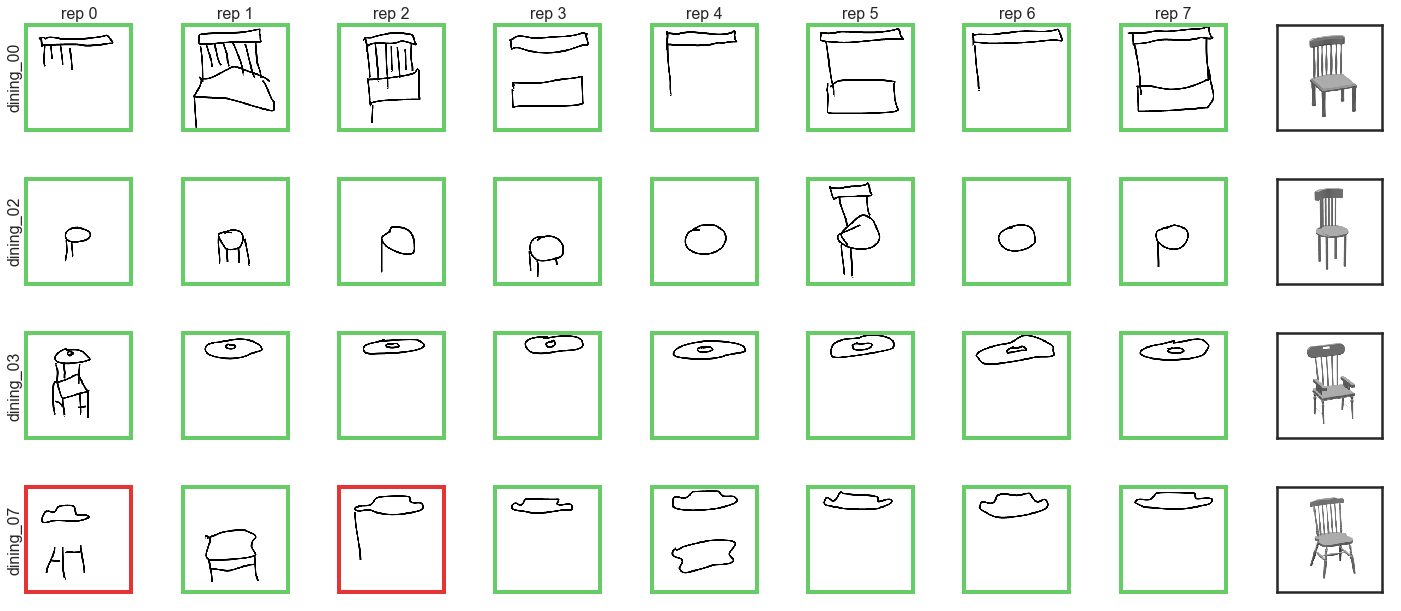

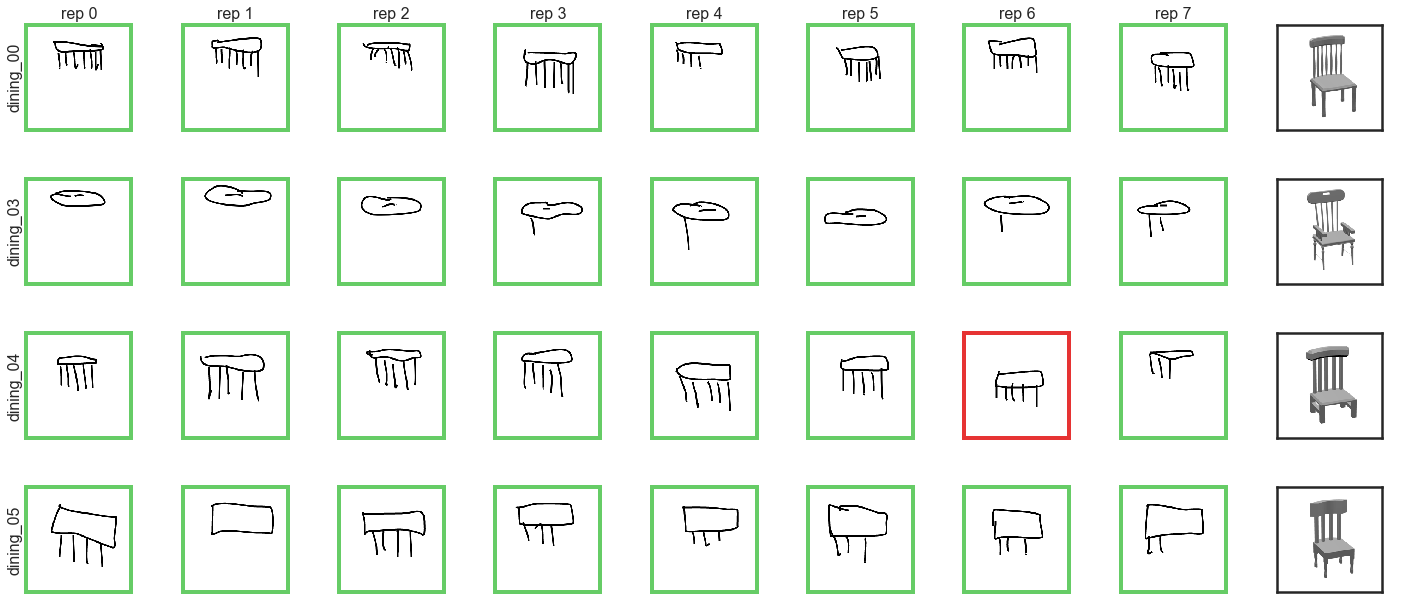

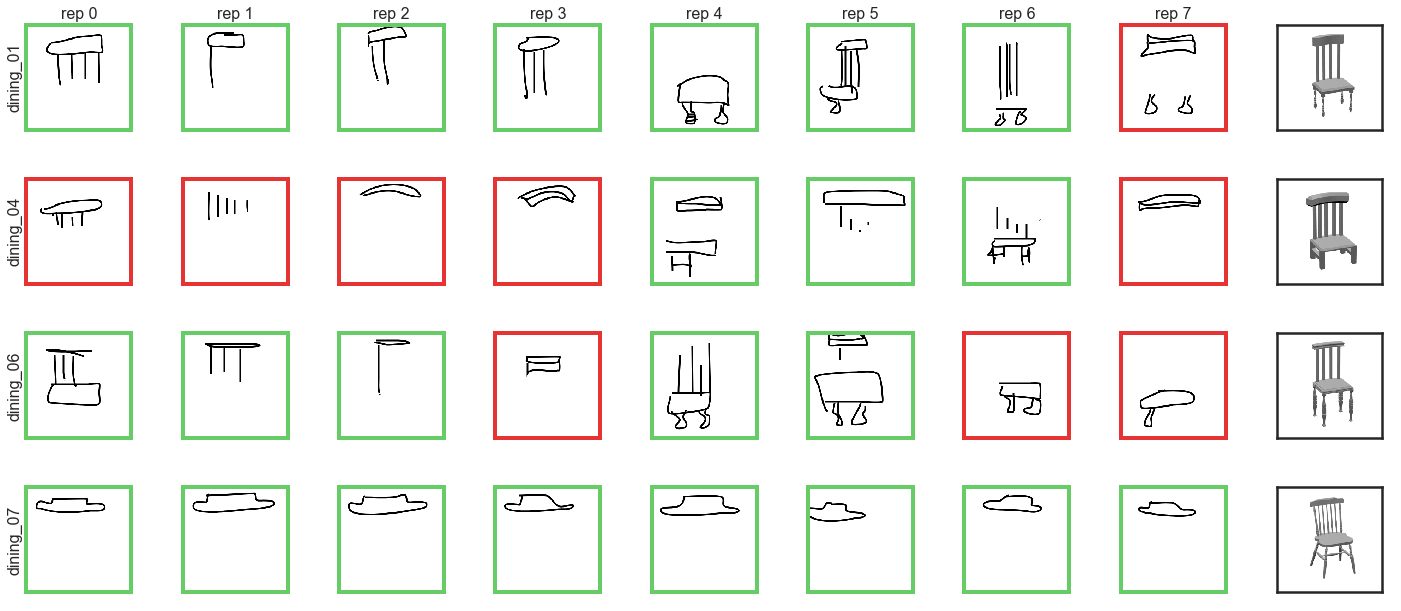

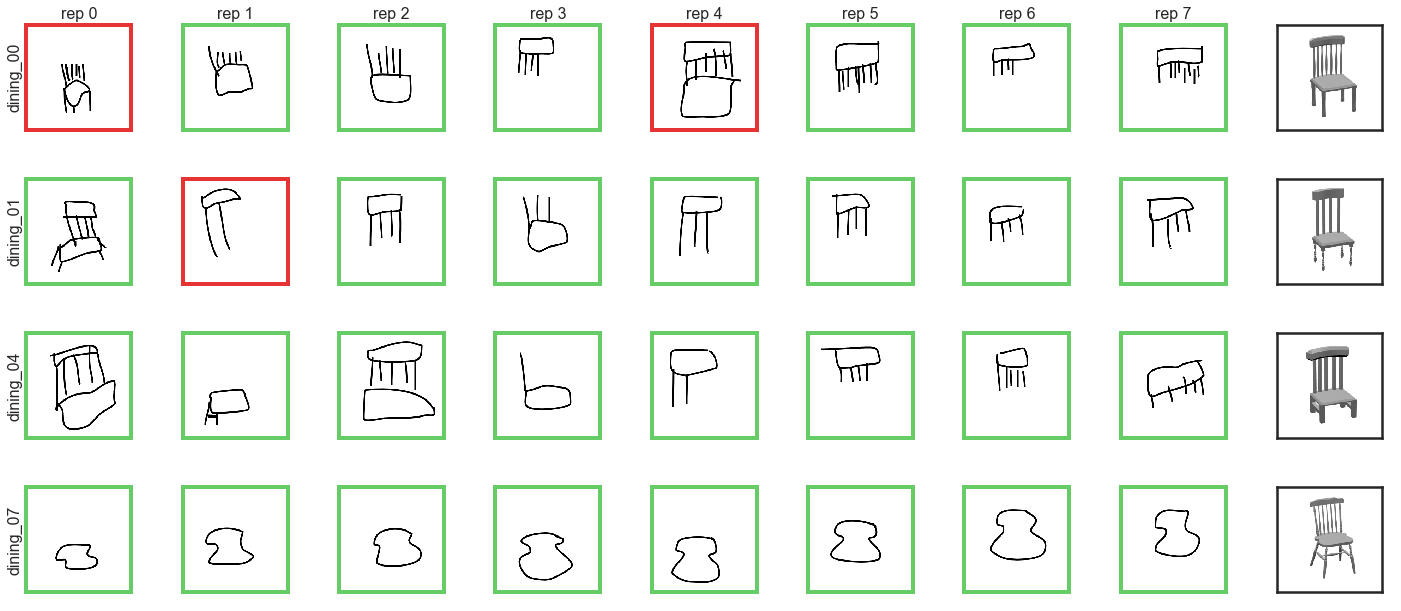

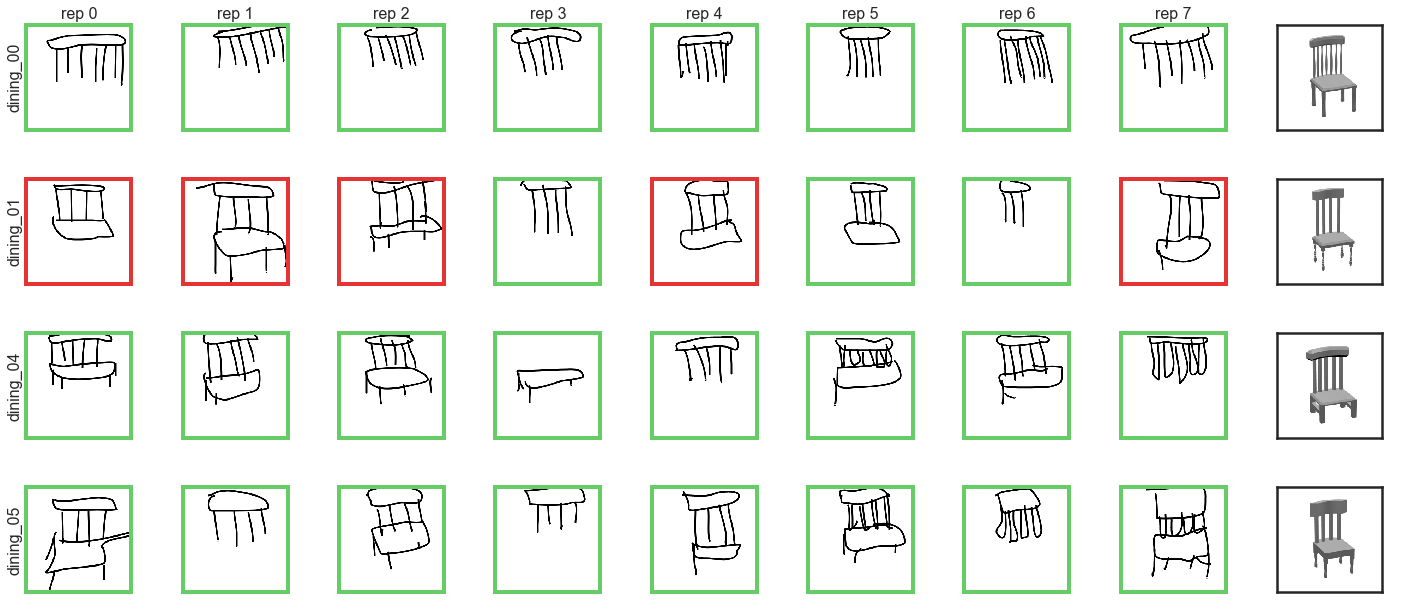

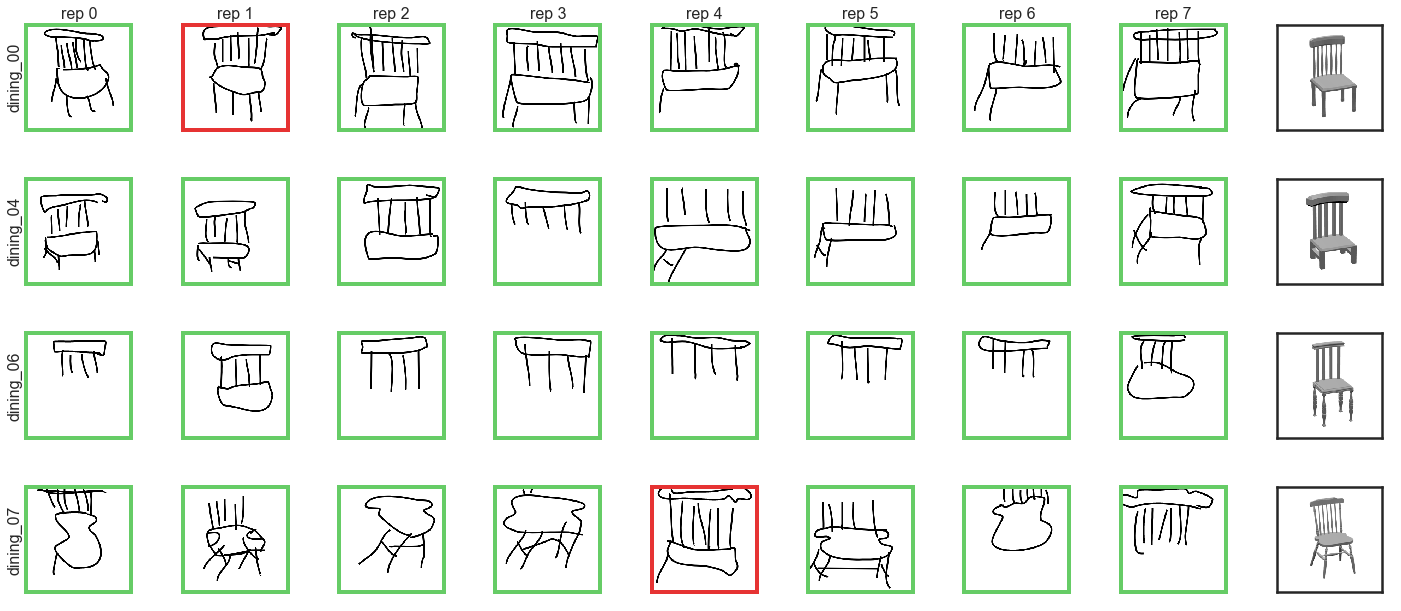

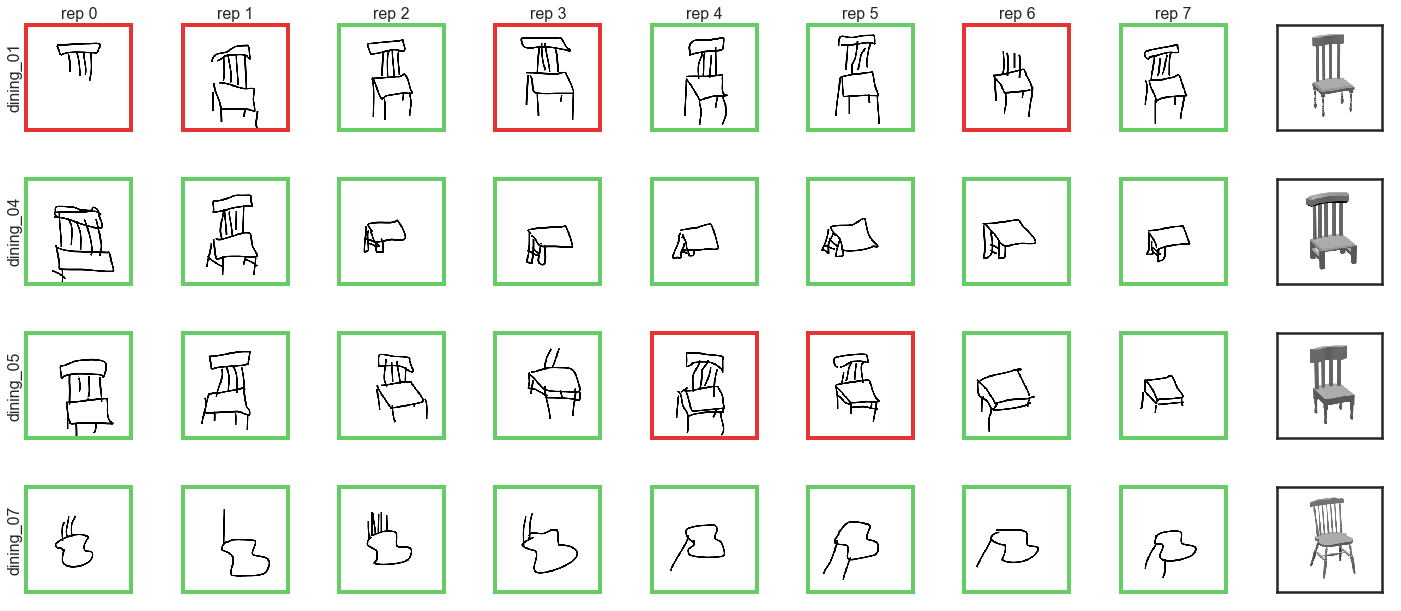

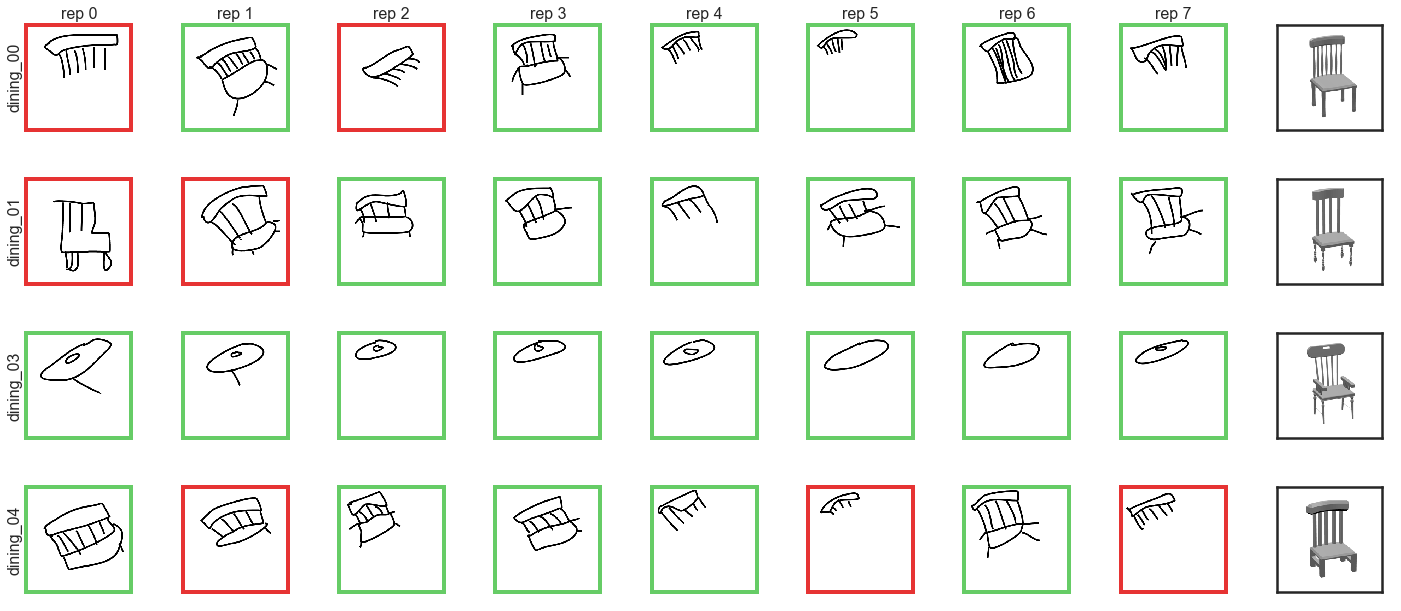

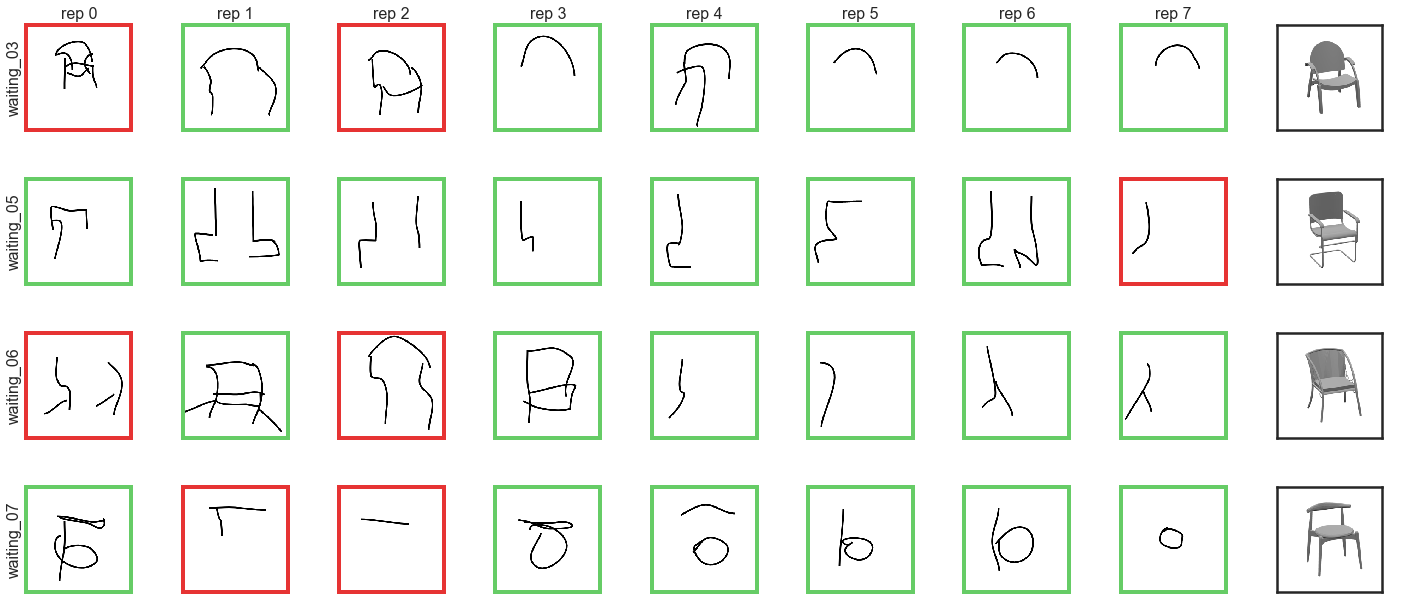

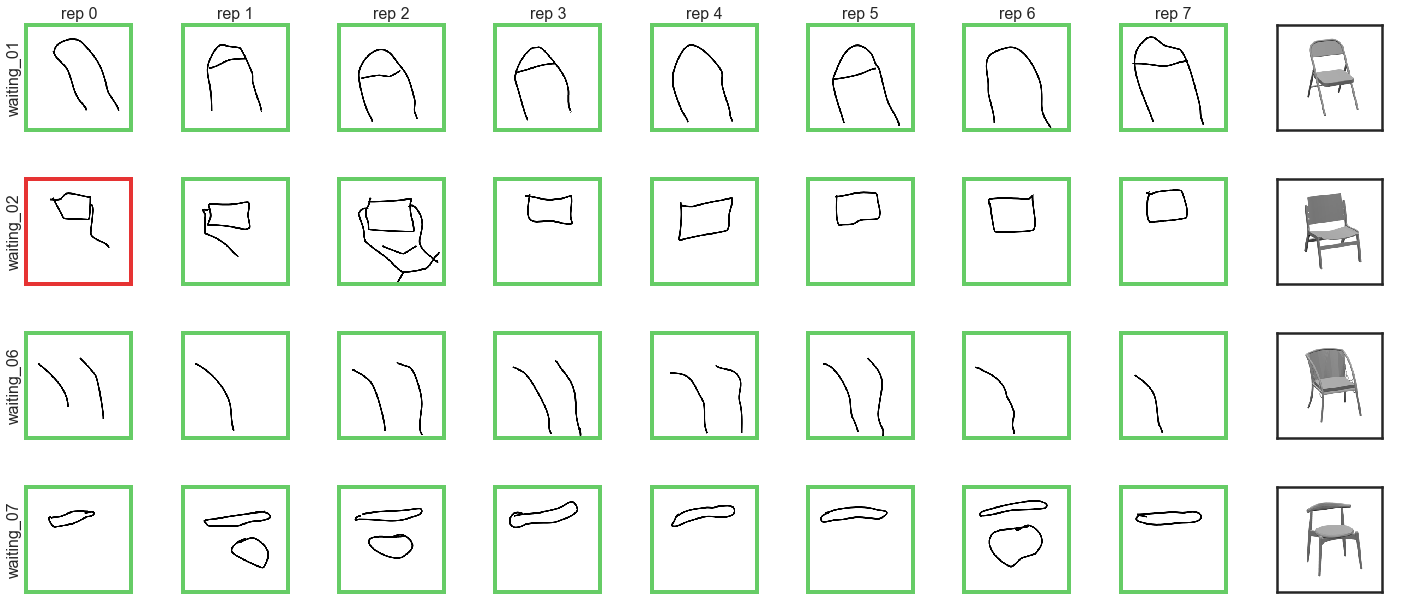

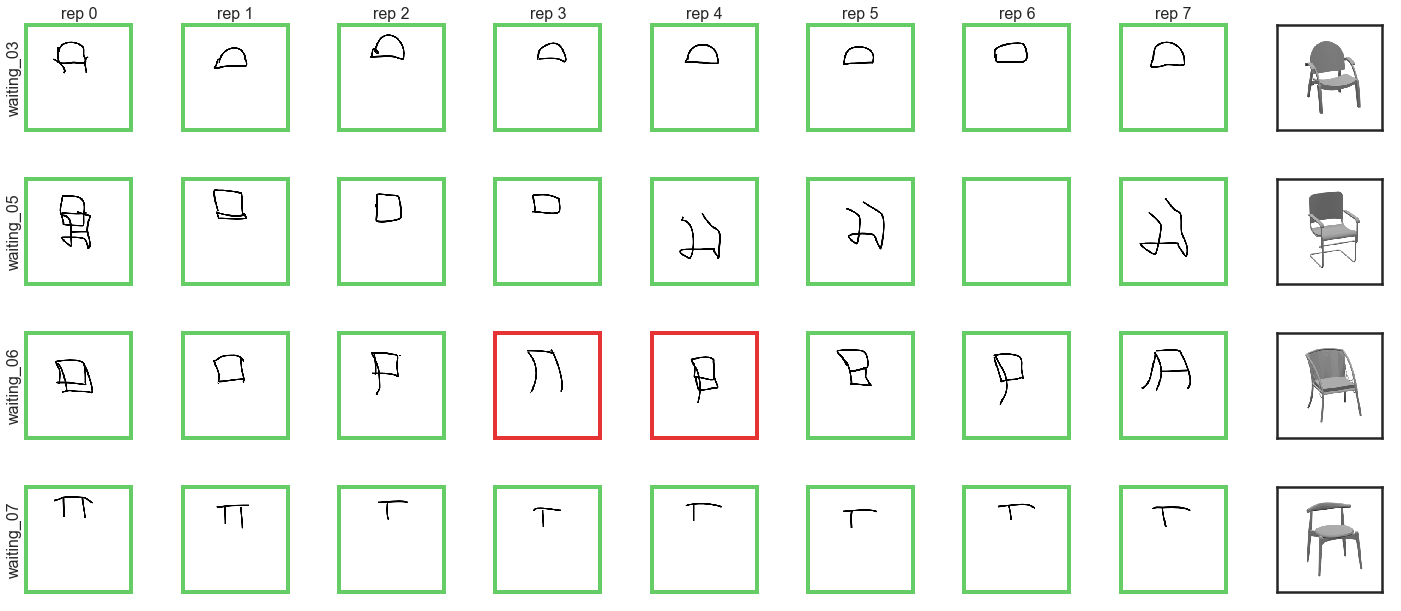

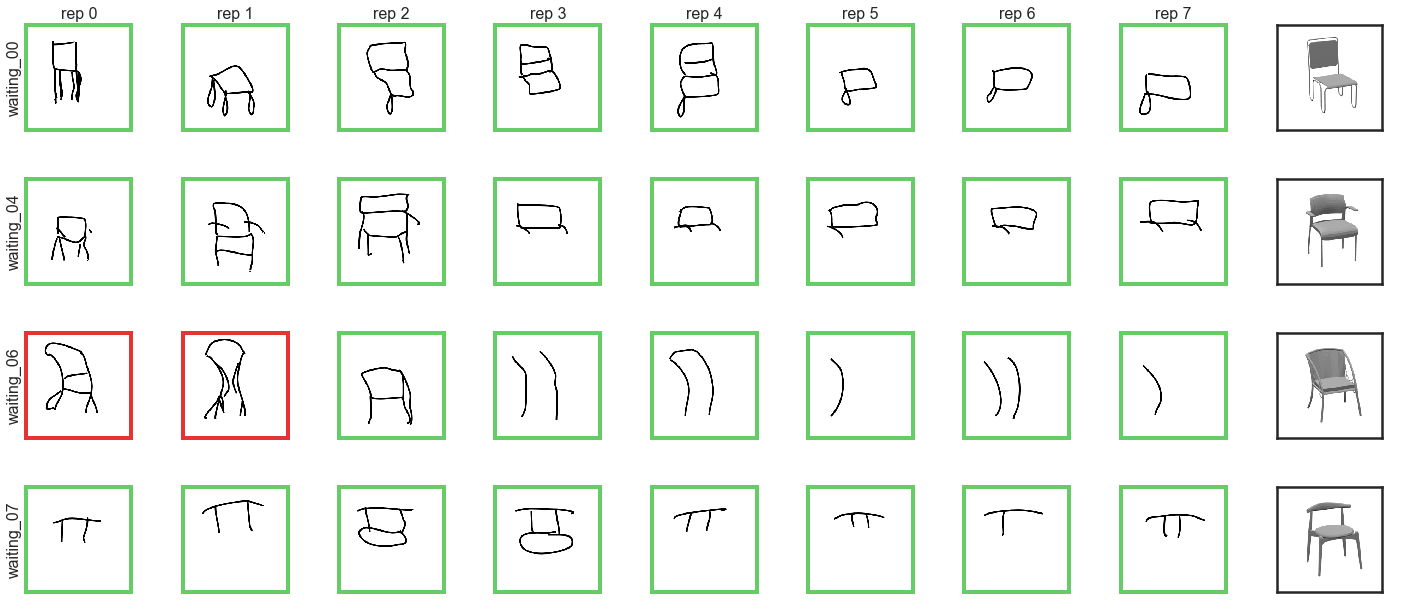

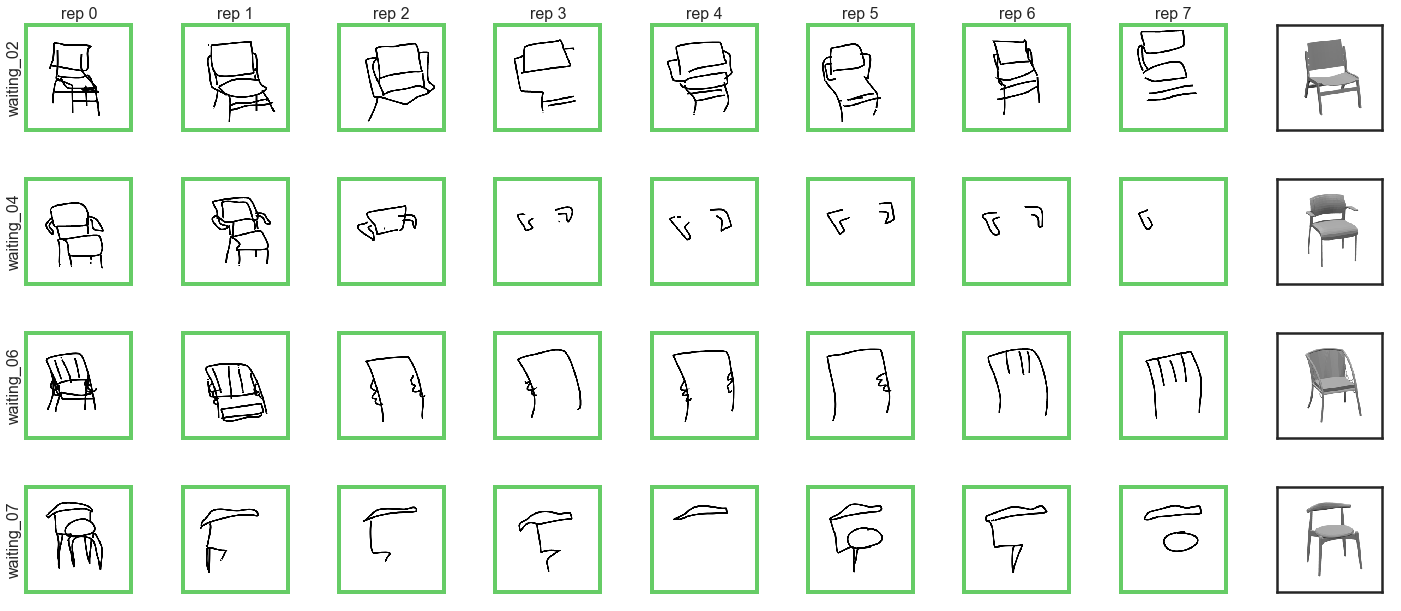

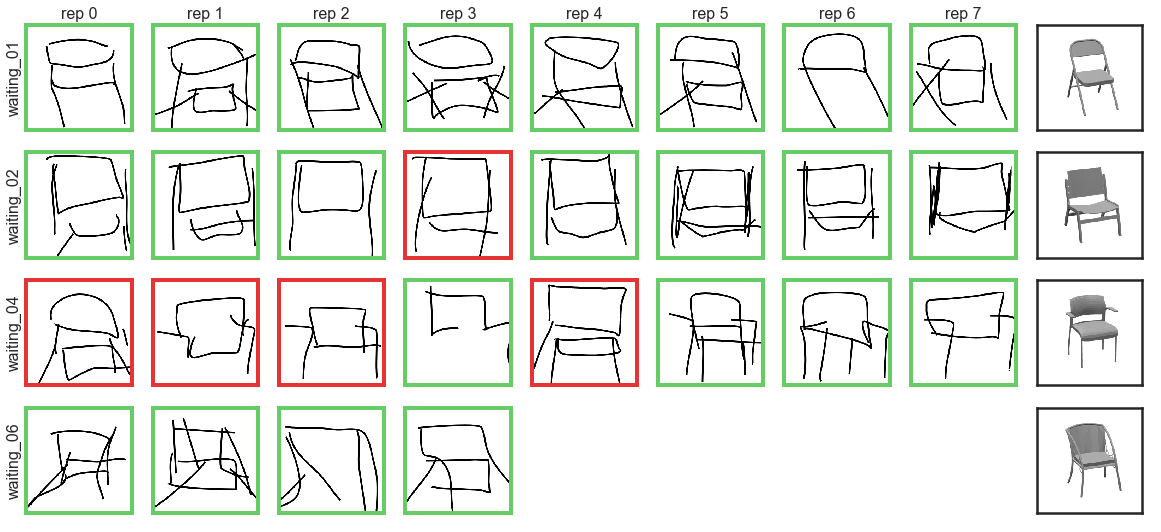

In [129]:
reload(h)
h.print_repeated_actual(D,
                                   complete_games,
                                   4)

##### printing last sketch of control condition next to repeated sketches 

Printing out sketches from game: 3558-8fa206a2-9b8c-4d67-a4ab-0832dc0d0f25
Printing out sketches from game: 6964-d6de9966-f3dd-45df-8d24-d5bfd5d46eb8
Printing out sketches from game: 4853-a05bfdd7-095c-4b93-bdde-2b99fd29c7a2
Printing out sketches from game: 5616-7114c020-0e81-482c-952b-b26fc66076a0
Printing out sketches from game: 9817-6f2a66db-fc24-482d-aa20-1980ad6f524e
Printing out sketches from game: 7527-5ab8c64c-3f95-4864-bb6a-f9cad4b0d34e
Printing out sketches from game: 1820-86afdf51-4b4c-43a9-a9e1-e6e20618de1b
Printing out sketches from game: 7438-c77fa69e-d41c-41a4-b530-fc2809c07323
Printing out sketches from game: 9075-d6c9b0a6-bfb2-4148-ae19-d0da518aef97
Printing out sketches from game: 7637-26870e81-faae-4521-a2e9-10424526a22c


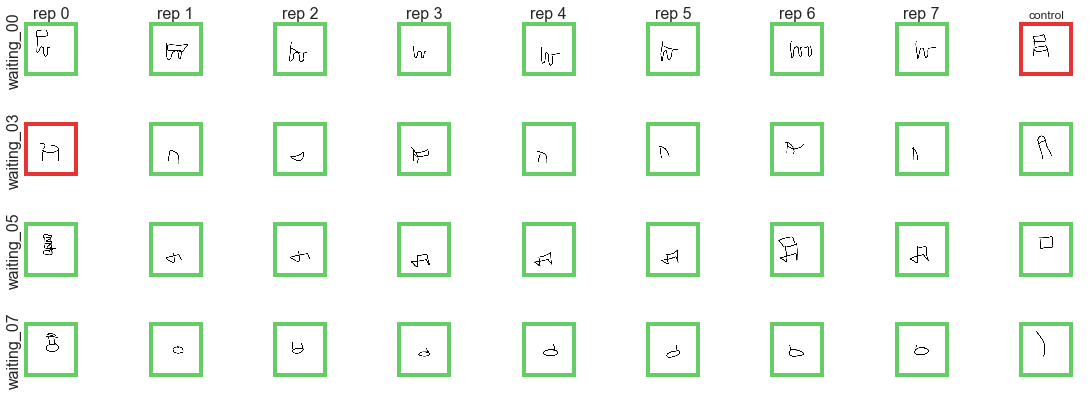

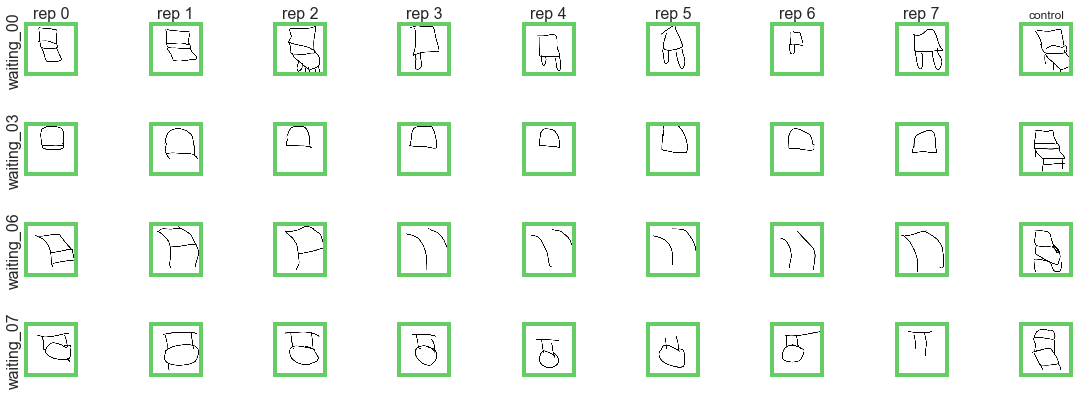

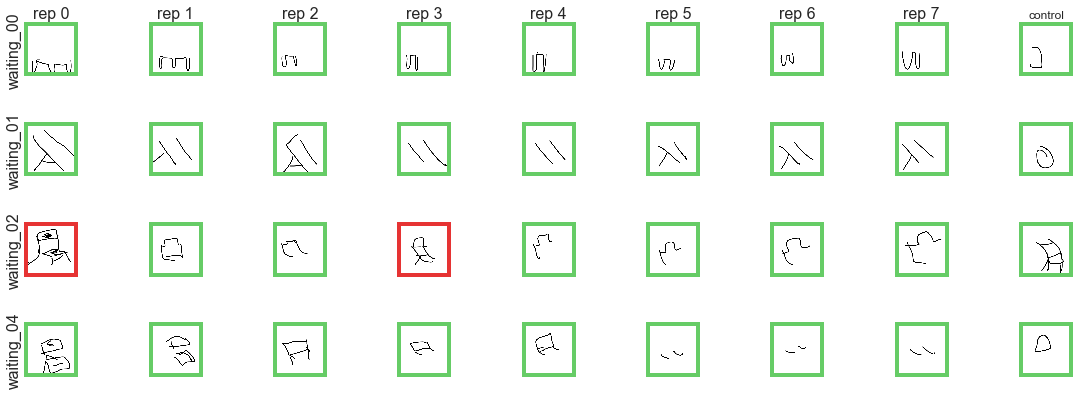

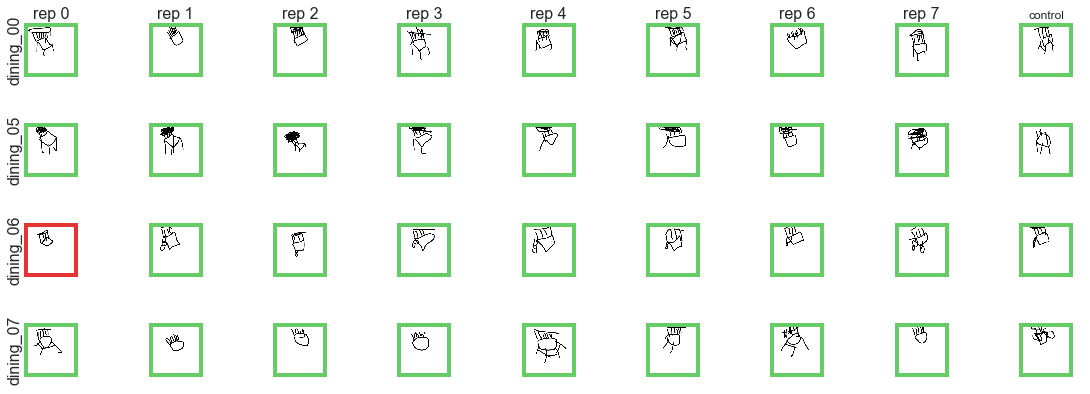

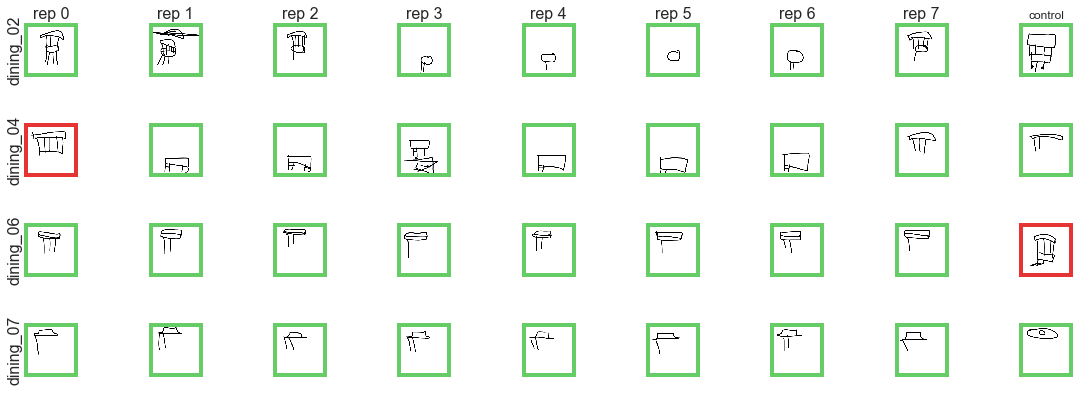

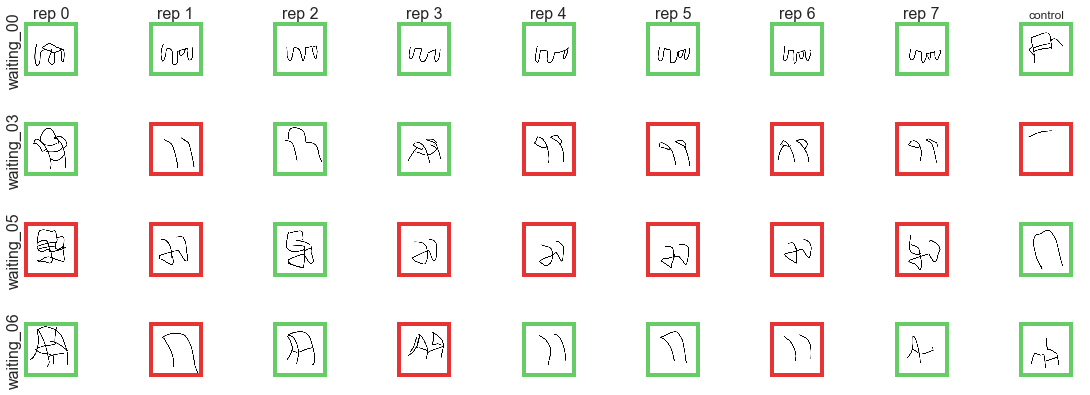

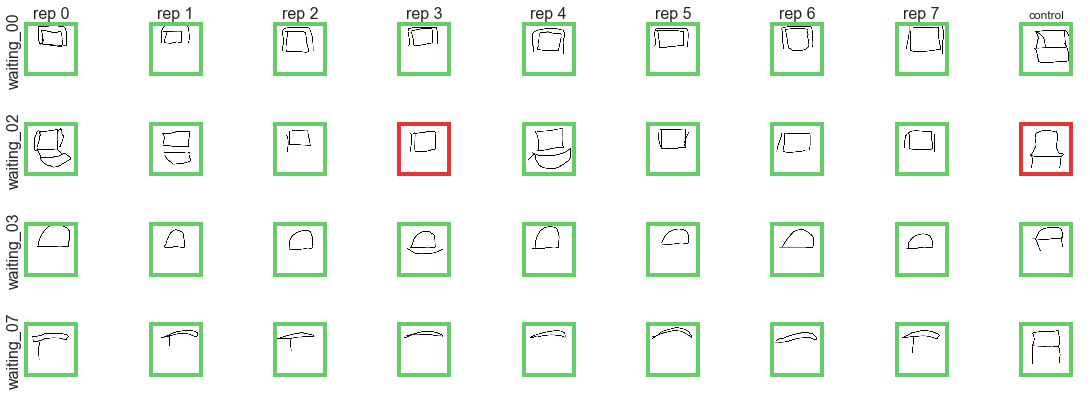

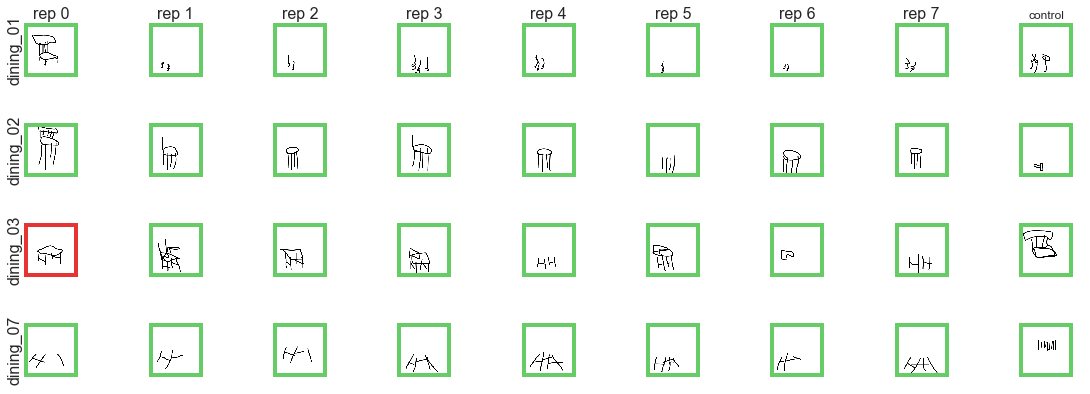

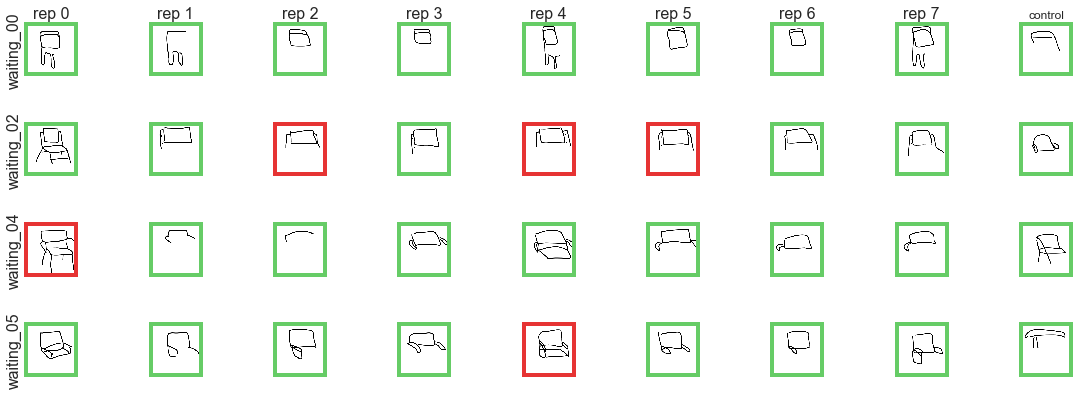

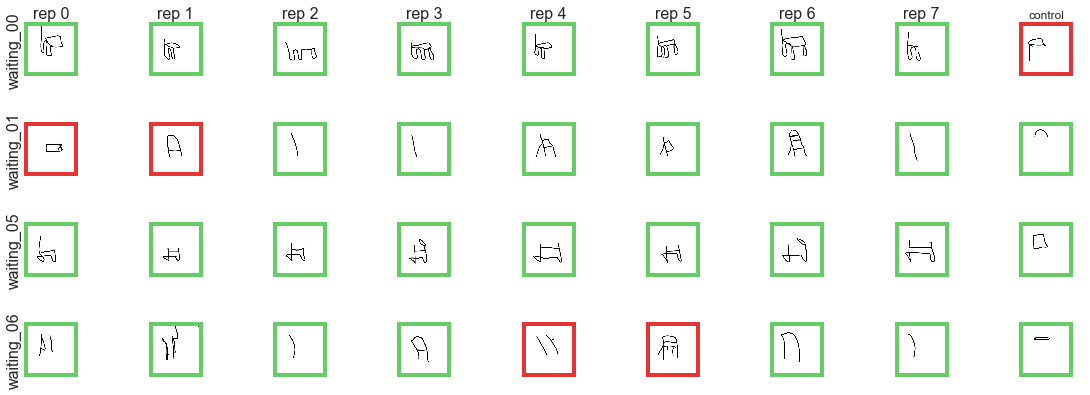

In [48]:
reload(h)
h.print_repeated_control(D,
                                   complete_games,
                                  4)